# **CMPUT 466/566 - CNN [ 25 marks]**


### **RESOURCES**
This assignment requires some basic knowledge of Pytorch which can be found in the following links:


1.   [Tensors](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html)
2.   [Build the Neural Network](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)
3. [Optimizing Model Parameters](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html)
4. [torch.nn](https://pytorch.org/docs/stable/nn.html)
5. [ResNet](https://pytorch.org/hub/pytorch_vision_resnet/)




### **DATASET**
The dataset is from [Kaggle](https://www.kaggle.com/datasets/die9origephit/children-vs-adults-images) and has been modified for some questions. The shared ***'balanced_data'*** folder contains the balanced dataset and ***'imbalanced_data'*** contains its modified version for Part IV with class imbalance. 

The dataset can be found [here](https://drive.google.com/drive/folders/1WMYnKezCICtLNwnp9-eeK0220X6Hjlfm?usp=sharing) 

Load the data on Google colab from Google drive:
1. Click on the Google Drive link of the **datasets** folder (make sure you login with your ualberta.ca email address)
2. Click on the drop down next to the name of the folder and select **Add Shortcut to Drive**

<center><img src='https://drive.google.com/uc?id=155oG91lcrqIxLQ1K3XJUzBLhrcOMmkqn' width="300" 
     height="400" ></center>

4. Come back to the **copy of this colab notebook** and mount the drive by running the cell below


In [1]:
from google.colab import drive
#make sure you give the necessary authorization for colab to access your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


5. Click Connect to **Google Drive**


<center><img src='https://drive.google.com/uc?id=1vVU4anE7Wo_BRBDrW_dZ8_ck-BbMmbLR' width="800" 
     height="150" ></center>


6. **Choose your ualberta.ca account**

<center><img src='https://drive.google.com/uc?id=1GkRAHOxpgAe4_Dsb0MY1ZdcR5RfyWxne' width="300" 
     height="400" align='middle' ></center>

7. **Grant permission**


<center><img src='https://drive.google.com/uc?id=17qYsveplhjnynP-tmPQnhZSEmv_x3oa7' width="400" 
     height="700" align='middle' ></center>


8. If you want to access a folder called **'datasets'**, you can do this with:



```
dataset_dir = '/content/drive/MyDrive/datasets'
```





In [2]:
'''
Follow the above steps and include the paths for training and test datasets
'''
main_path = '/content/drive/MyDrive/datasets/balanced_data/train' #ENTER PATH HERE
test_path = '/content/drive/MyDrive/datasets/balanced_data/test' #ENTER PATH HERE

### **Part I:  Activation functions for CNN [ 6 marks ]**

In [1]:
#Loading necessary libraries
import numpy as np
import pandas as pd 
import skimage.io
from skimage import color
from skimage import io
import glob
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler, Adam, SGD
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.utils.data as data
import numpy as np
import os
import glob
import time
from sklearn.metrics import balanced_accuracy_score
from torch.autograd import Variable
from torch.nn import Linear, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.nn.modules.conv import ConvTranspose2d, Conv2d
from google.colab.patches import cv2_imshow
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tqdm import tqdm
from torchvision import models
'''
Import any necessary libraries here to keep your code organized
'''
#import <some_library> 
#from <something> import <something>
from torch.utils.data import WeightedRandomSampler

In [4]:
'''
DO NOT ALTER THE FOLLOWING CODE
'''
'''
NEW CHANGE on 16th Novemeber, 2022
Add the line below
'''
torch.cuda.empty_cache()
torch.manual_seed(0)
'''
Add the above line
'''
'''
DO NOT ALTER THE FOLLOWING CODE
'''
my_transforms = transforms.Compose([transforms.Resize((224,224)),   transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
BATCH_SIZE = 16
IMAGE_SIZE = 32
NUM_CHANNELS = 3
n_epochs = 50 # the cnn will be trained for 50 epochs
dataset = datasets.ImageFolder(root=main_path, transform=my_transforms)
dataset_size = dataset.__len__() #compute the length of the training dataset
train_count = int(dataset_size * 0.8) #divide the training dataset to training and validation splits
val_count = dataset_size - train_count # keep the training proportion to 1 if no validation is required
train_dataset, valid_dataset = data.random_split(dataset, [train_count, val_count]) #perform a random split on the dataset based on the train and validation proportion
y_train_indices = train_dataset.indices
y_train = [dataset.targets[i] for i in y_train_indices] #assign the labels or target variables to y_train (classes)
test_data = datasets.ImageFolder(test_path, transform=my_transforms)
'''
Following train, validation and test dataloaders will also be used in Part III: Resnets
'''
'''
NEW CHANGE on 16th Novemeber, 2022
'''
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=2, )
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, )
'''
NEW CHANGE on 16th Novemeber, 2022
'''
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #check for gpu
print('Using ',device,'for model training') #print the device status

Using  cuda:0 for model training


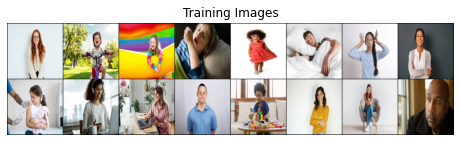

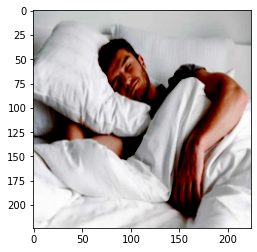

Label: 0


In [5]:
#Visualize some training images
'''
DO NOT ALTER THE FOLLOWING CODE
'''
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()
plt.imshow(real_batch[0][5].permute(1,2,0), vmin=0, vmax=255)
plt.show()
print(f"Label: {real_batch[1][5]}")

In [5]:
'''
DO NOT ALTER THE FOLLOWING CODE
'''
def make_train_step(model, optimizer, loss_fn):
  '''
  INPUT: model, optimizer, loss function
  OUTPUT: train step
  '''
  def train_step(x,y):
    '''
    This function is used to train the model and update the model parameters. Do not change this function
    '''
    #make prediction
    yhat = model(x)
    #enter train mode
    model.train()
    #compute loss
    loss = loss_fn(yhat,y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss
  return train_step

In [6]:
'''
DO NOT ALTER THE FOLLOWING CODE
'''
def train_model(model,n_epochs, loss_fn, train_step):
  '''
  This is the main function which is used to train the model, update weights, calculate loss and save the best model
  '''
  train_losses = []
  val_losses = []
  epoch_train_losses = []
  epoch_val_losses = []
  for epoch in range(n_epochs):
    epoch_loss = 0
    for i ,data in tqdm(enumerate(train_dataloader), total = len(train_dataloader)): #iterate ove batches
      x_batch , y_batch = data
      x_batch = x_batch.to('cuda') #move to gpu
      y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
      y_batch = y_batch.to('cuda') #move to gpu
      loss = train_step(x_batch, y_batch)
      epoch_loss += loss/len(train_dataloader) 
      train_losses.append(loss.cpu().detach().numpy())
    epoch_train_losses.append(epoch_loss)
    print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))
    #validation does not require gradient
    with torch.no_grad():
      cum_loss = 0
      for x_batch, y_batch in valid_dataloader:
        x_batch = x_batch.to('cuda')
        y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
        y_batch = y_batch.to('cuda')
        model.eval()#model to eval mode
        yhat = model(x_batch)
        val_loss = loss_fn(yhat,y_batch)
        cum_loss += loss/len(valid_dataloader)
        val_losses.append(val_loss.item())
      epoch_val_losses.append(cum_loss)
      print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))   
      best_loss = min(epoch_val_losses)  
      #save best model
      if cum_loss <= best_loss:
        best_model_wts = model.state_dict()  
  #load best model
  model.load_state_dict(best_model_wts)
  return model, train_losses,val_losses

def plot_losses(train_losses,val_losses):
  '''
  This function can be used to plot the training and validation losses. You can use this 
  function to analyse the losses and judge if model was overfitting or if model shows some 
  unusual behaviour. 
  '''
  plt.plot(train_losses, label='Training loss')
  plt.plot(val_losses, label='Validation loss')
  plt.legend()
  plt.show()

def inference(model,test_data):
  '''
  As we are doing binary classification, this function uses sigmoid to change class probabilities 
  to either 0 or 1 class. 
  '''
  y_pred = []
  y_true = []
  for idx in range(1, len(test_data)):
    y_true.append( test_data[idx][1])
    sample = torch.unsqueeze(test_data[idx][0], dim=0).to('cuda')
    if torch.sigmoid(model(sample)) < 0.5:
      y_pred.append(0)
    else:
      y_pred.append(1)
  return y_pred, y_true

def calc_loss(model, n_epochs):
  '''
  This function drives the training function, assigns the loss fuction and sets the optimiizer.
  '''
  loss_fn = BCEWithLogitsLoss() 
  optimizer = torch.optim.Adam(model.parameters()) 
  train_step = make_train_step(model, optimizer, loss_fn)
  trained_model, train_losses, val_losses = train_model(model,n_epochs, loss_fn, train_step)
  return trained_model

def calc_accuracy(trained_model):
  '''
  This function is used for returning the calculated accuracies.
  '''
  y_pred, y_true = inference(trained_model,test_data)
  target_names = ['Adults', 'Kids']
  print('the accuracy is',accuracy_score(y_true, y_pred))
  print(classification_report(y_true, y_pred, target_names=target_names))
  print('the balanced accuracy is',balanced_accuracy_score(y_true, y_pred))
  return accuracy_score(y_true, y_pred)

#### **Consider the following code snippet for a Neural Network**

This Network is a very simple Network for your reference to implement a Neural Network of any given architecture. 


```
class Net(Module):   
    
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(NUM_CHANNELS, IMAGE_SIZE, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(IMAGE_SIZE),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            MaxPool2d(kernel_size=2, stride=2),
        )
        self.linear_layers = Sequential(
            Linear(100352, 1)
        )
    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

trained_model = calc_loss(model, n_epochs)
calc_accuracy(trained_model)
```



#### **(1) Build a CNN for the following Model Architecture [3 marks]**


```
Net(
  (cnn_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_2): Sequential(
    (0): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_4): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_5): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_6): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=50176, out_features=4096, bias=True)
  )
  (fully_2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
  )
  (fully_3): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=1000, bias=True)
  )
  (fully_4): Sequential(
    (0): Linear(in_features=1000, out_features=1, bias=True)
  )
)
```

The codebase is as follows:


In [ ]:
from torch.nn.modules.conv import ConvTranspose2d, Conv2d
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        '''
        Write the 6 CNNs and 4 fully connected CNNs here:
        '''
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            # Defining another 2D convolution layer
            Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        )
        self.linear_layers = Sequential(
            Dropout(p=0.5, inplace=False),
            Linear(in_features=50176, out_features=4096, bias=True),

            Dropout(p=0.5, inplace=False),
            Linear(in_features=4096, out_features=4096, bias=True),

            Dropout(p=0.5, inplace=False),
            Linear(in_features=4096, out_features=1000, bias=True),

            Linear(in_features=1000, out_features=1, bias=True)
        )
    def forward(self, x):
        '''
        Define the forward pass
        '''
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
'''
DO NOT ALTER THE FOLLOWING CODE
'''
model = Net()
optimizer = Adam(model.parameters(), lr=0.07)
criterion = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)
trained_model = calc_loss(model, n_epochs) #train the model
calc_accuracy(trained_model) # report the accuracy 

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

100%|██████████| 34/34 [00:09<00:00,  3.64it/s]


Epoch : 1, train loss : 113.38008117675781


Epoch : 1, val loss : 25.674484252929688


100%|██████████| 34/34 [00:09<00:00,  3.67it/s]


Epoch : 2, train loss : 15.392705917358398


Epoch : 2, val loss : 5.662010192871094


100%|██████████| 34/34 [00:09<00:00,  3.59it/s]


Epoch : 3, train loss : 4.9140214920043945


Epoch : 3, val loss : 3.8901753425598145


100%|██████████| 34/34 [00:09<00:00,  3.54it/s]


Epoch : 4, train loss : 1.9553179740905762


Epoch : 4, val loss : 1.7012877464294434


100%|██████████| 34/34 [00:09<00:00,  3.62it/s]


Epoch : 5, train loss : 1.0678104162216187


Epoch : 5, val loss : 0.6685365438461304


100%|██████████| 34/34 [00:09<00:00,  3.65it/s]


Epoch : 6, train loss : 1.250176191329956


Epoch : 6, val loss : 0.4806652367115021


100%|██████████| 34/34 [00:09<00:00,  3.55it/s]


Epoch : 7, train loss : 0.9917145371437073


Epoch : 7, val loss : 1.0930163860321045


100%|██████████| 34/34 [00:09<00:00,  3.68it/s]


Epoch : 8, train loss : 0.9379223585128784


Epoch : 8, val loss : 0.9610726237297058


100%|██████████| 34/34 [00:09<00:00,  3.68it/s]


Epoch : 9, train loss : 0.9587901830673218


Epoch : 9, val loss : 0.821089506149292


100%|██████████| 34/34 [00:09<00:00,  3.66it/s]


Epoch : 10, train loss : 0.8643788695335388


Epoch : 10, val loss : 1.068486213684082


100%|██████████| 34/34 [00:09<00:00,  3.64it/s]


Epoch : 11, train loss : 0.8535059690475464


Epoch : 11, val loss : 0.7103026509284973


100%|██████████| 34/34 [00:09<00:00,  3.60it/s]


Epoch : 12, train loss : 0.8375294208526611


Epoch : 12, val loss : 1.2064330577850342


100%|██████████| 34/34 [00:09<00:00,  3.63it/s]


Epoch : 13, train loss : 0.945214033126831


Epoch : 13, val loss : 1.3883061408996582


100%|██████████| 34/34 [00:09<00:00,  3.63it/s]


Epoch : 14, train loss : 0.8053640127182007


Epoch : 14, val loss : 1.0543897151947021


100%|██████████| 34/34 [00:09<00:00,  3.64it/s]


Epoch : 15, train loss : 0.7730908989906311


Epoch : 15, val loss : 0.8387245535850525


100%|██████████| 34/34 [00:09<00:00,  3.62it/s]


Epoch : 16, train loss : 0.7216094732284546


Epoch : 16, val loss : 0.4970289170742035


100%|██████████| 34/34 [00:09<00:00,  3.63it/s]


Epoch : 17, train loss : 0.7840367555618286


Epoch : 17, val loss : 0.3618045449256897


100%|██████████| 34/34 [00:09<00:00,  3.52it/s]


Epoch : 18, train loss : 0.8982576727867126


Epoch : 18, val loss : 1.153476595878601


100%|██████████| 34/34 [00:09<00:00,  3.60it/s]


Epoch : 19, train loss : 0.6904845237731934


Epoch : 19, val loss : 0.8630763292312622


100%|██████████| 34/34 [00:09<00:00,  3.61it/s]


Epoch : 20, train loss : 0.6616950631141663


Epoch : 20, val loss : 1.1415553092956543


100%|██████████| 34/34 [00:09<00:00,  3.59it/s]


Epoch : 21, train loss : 0.6757354140281677


Epoch : 21, val loss : 0.6630624532699585


100%|██████████| 34/34 [00:09<00:00,  3.58it/s]


Epoch : 22, train loss : 0.5849753022193909


Epoch : 22, val loss : 0.6458946466445923


100%|██████████| 34/34 [00:09<00:00,  3.41it/s]


Epoch : 23, train loss : 0.7447038888931274


Epoch : 23, val loss : 0.8700586557388306


100%|██████████| 34/34 [00:09<00:00,  3.59it/s]


Epoch : 24, train loss : 0.6848704218864441


Epoch : 24, val loss : 0.9088891744613647


100%|██████████| 34/34 [00:09<00:00,  3.57it/s]


Epoch : 25, train loss : 0.9029714465141296


Epoch : 25, val loss : 0.9262161254882812


100%|██████████| 34/34 [00:09<00:00,  3.55it/s]


Epoch : 26, train loss : 1.0327767133712769


Epoch : 26, val loss : 1.4960955381393433


100%|██████████| 34/34 [00:09<00:00,  3.59it/s]


Epoch : 27, train loss : 0.8185552954673767


Epoch : 27, val loss : 0.6370798349380493


100%|██████████| 34/34 [00:09<00:00,  3.43it/s]


Epoch : 28, train loss : 0.9123225808143616


Epoch : 28, val loss : 0.566102147102356


100%|██████████| 34/34 [00:09<00:00,  3.58it/s]


Epoch : 29, train loss : 1.0069708824157715


Epoch : 29, val loss : 0.3592979609966278


100%|██████████| 34/34 [00:09<00:00,  3.58it/s]


Epoch : 30, train loss : 1.1610206365585327


Epoch : 30, val loss : 2.3980319499969482


100%|██████████| 34/34 [00:09<00:00,  3.60it/s]


Epoch : 31, train loss : 1.753995656967163


Epoch : 31, val loss : 1.905031681060791


100%|██████████| 34/34 [00:09<00:00,  3.58it/s]


Epoch : 32, train loss : 5.183779716491699


Epoch : 32, val loss : 0.46770405769348145


100%|██████████| 34/34 [00:10<00:00,  3.34it/s]


Epoch : 33, train loss : 10.897502899169922


Epoch : 33, val loss : 19.79132843017578


100%|██████████| 34/34 [00:09<00:00,  3.58it/s]


Epoch : 34, train loss : 52.730560302734375


Epoch : 34, val loss : 266.17578125


100%|██████████| 34/34 [00:09<00:00,  3.58it/s]


Epoch : 35, train loss : 1280.6123046875


Epoch : 35, val loss : 1058.4053955078125


100%|██████████| 34/34 [00:09<00:00,  3.60it/s]


Epoch : 36, train loss : 5779.2353515625


Epoch : 36, val loss : 1750.1265869140625


100%|██████████| 34/34 [00:09<00:00,  3.57it/s]


Epoch : 37, train loss : 1623.3123779296875


Epoch : 37, val loss : 714.3755493164062


100%|██████████| 34/34 [00:09<00:00,  3.43it/s]


Epoch : 38, train loss : 376.1910095214844


Epoch : 38, val loss : 496.49334716796875


100%|██████████| 34/34 [00:09<00:00,  3.58it/s]


Epoch : 39, train loss : 124.92267608642578


Epoch : 39, val loss : 41.51544952392578


100%|██████████| 34/34 [00:09<00:00,  3.59it/s]


Epoch : 40, train loss : 80.09747314453125


Epoch : 40, val loss : 118.00894165039062


100%|██████████| 34/34 [00:09<00:00,  3.56it/s]


Epoch : 41, train loss : 59.75107192993164


Epoch : 41, val loss : 39.27111053466797


100%|██████████| 34/34 [00:09<00:00,  3.57it/s]


Epoch : 42, train loss : 24.554697036743164


Epoch : 42, val loss : 35.290855407714844


100%|██████████| 34/34 [00:09<00:00,  3.55it/s]


Epoch : 43, train loss : 20.00562858581543


Epoch : 43, val loss : 27.344970703125


100%|██████████| 34/34 [00:09<00:00,  3.58it/s]


Epoch : 44, train loss : 20.713529586791992


Epoch : 44, val loss : 12.072805404663086


100%|██████████| 34/34 [00:09<00:00,  3.58it/s]


Epoch : 45, train loss : 23.83782958984375


Epoch : 45, val loss : 26.377037048339844


100%|██████████| 34/34 [00:09<00:00,  3.60it/s]


Epoch : 46, train loss : 26.119722366333008


Epoch : 46, val loss : 18.94969367980957


100%|██████████| 34/34 [00:09<00:00,  3.59it/s]


Epoch : 47, train loss : 28.09427261352539


Epoch : 47, val loss : 21.78936767578125


100%|██████████| 34/34 [00:09<00:00,  3.54it/s]


Epoch : 48, train loss : 12.449796676635742


Epoch : 48, val loss : 18.318893432617188


100%|██████████| 34/34 [00:09<00:00,  3.57it/s]


Epoch : 49, train loss : 24.264476776123047


Epoch : 49, val loss : 30.468828201293945


100%|██████████| 34/34 [00:09<00:00,  3.58it/s]


Epoch : 50, train loss : 18.32427215576172


Epoch : 50, val loss : 6.611057281494141
the accuracy is 0.40336134453781514
              precision    recall  f1-score   support

      Adults       0.41      0.44      0.42        59
        Kids       0.40      0.37      0.38        60

    accuracy                           0.40       119
   macro avg       0.40      0.40      0.40       119
weighted avg       0.40      0.40      0.40       119

the balanced accuracy is 0.4036723163841808


0.40336134453781514

#### **(2) Activation Functions [3 marks]**
Plug in the following Activation Functions:

1. ReLU
2. SiLU
3. Sigmoid
4. Tanh
5. ELU


Your Network Architecture should be as follows:



```
Net(
  (cnn_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_2): Sequential(
    (0): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_4): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_5): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_6): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=50176, out_features=4096, bias=True)
    (2): YOUR ACTIVATION FUNCTION COMES HERE
  )
  (fully_2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
    (2): YOUR ACTIVATION FUNCTION COMES HERE
  )
  (fully_3): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=1000, bias=True)
    (2): YOUR ACTIVATION FUNCTION COMES HERE
  )
  (fully_4): Sequential(
    (0): Linear(in_features=1000, out_features=1, bias=True)
  )
)
```








In [ ]:
'''
ReLU
'''
from torch.nn.modules.conv import ConvTranspose2d, Conv2d
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        '''
        Write the 6 CNNs and 4 fully connected CNNs here
        '''
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            # Defining another 2D convolution layer
            Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            
            )

        self.linear_layers = Sequential(
            Dropout(p=0.5, inplace=False),
            Linear(in_features=50176, out_features=4096, bias=True),
            Dropout(p=0.5, inplace=False),
            nn.ReLU(),

            Dropout(p=0.5, inplace=False),
            Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(),

            Dropout(p=0.5, inplace=False),
            Linear(in_features=4096, out_features=1000, bias=True),
            nn.ReLU(),

            Linear(in_features=1000, out_features=1, bias=True)
        )
    def forward(self, x):
        '''
        Define the forward pass : 
        '''
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
        
'''
DO NOT ALTER THE FOLLOWING CODE
'''
model = Net()
optimizer = Adam(model.parameters(), lr=0.07)
criterion = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)
trained_model = calc_loss(model, n_epochs) #train the model
calc_accuracy(trained_model) # report the accuracy

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

100%|██████████| 34/34 [00:09<00:00,  3.68it/s]


Epoch : 1, train loss : 1.6192476749420166


Epoch : 1, val loss : 0.6238212585449219


100%|██████████| 34/34 [00:09<00:00,  3.51it/s]


Epoch : 2, train loss : 0.712020218372345


Epoch : 2, val loss : 0.710860550403595


100%|██████████| 34/34 [00:09<00:00,  3.56it/s]


Epoch : 3, train loss : 0.6759021282196045


Epoch : 3, val loss : 0.6520535349845886


100%|██████████| 34/34 [00:09<00:00,  3.55it/s]


Epoch : 4, train loss : 0.708302915096283


Epoch : 4, val loss : 0.6734241843223572


100%|██████████| 34/34 [00:09<00:00,  3.60it/s]


Epoch : 5, train loss : 0.6770449876785278


Epoch : 5, val loss : 0.6609408855438232


100%|██████████| 34/34 [00:09<00:00,  3.61it/s]


Epoch : 6, train loss : 0.6772757172584534


Epoch : 6, val loss : 0.7548094391822815


100%|██████████| 34/34 [00:09<00:00,  3.59it/s]


Epoch : 7, train loss : 0.6649172306060791


Epoch : 7, val loss : 0.6501893997192383


100%|██████████| 34/34 [00:09<00:00,  3.58it/s]


Epoch : 8, train loss : 0.6709481477737427


Epoch : 8, val loss : 0.5231376886367798


100%|██████████| 34/34 [00:09<00:00,  3.59it/s]


Epoch : 9, train loss : 0.6534956097602844


Epoch : 9, val loss : 0.6894338726997375


100%|██████████| 34/34 [00:09<00:00,  3.62it/s]


Epoch : 10, train loss : 0.6988785266876221


Epoch : 10, val loss : 0.6728277802467346


100%|██████████| 34/34 [00:09<00:00,  3.60it/s]


Epoch : 11, train loss : 0.6549556255340576


Epoch : 11, val loss : 0.6834229230880737


100%|██████████| 34/34 [00:09<00:00,  3.61it/s]


Epoch : 12, train loss : 0.6570022702217102


Epoch : 12, val loss : 0.4694156050682068


100%|██████████| 34/34 [00:10<00:00,  3.38it/s]


Epoch : 13, train loss : 0.660111129283905


Epoch : 13, val loss : 0.692756712436676


100%|██████████| 34/34 [00:09<00:00,  3.69it/s]


Epoch : 14, train loss : 0.7002794146537781


Epoch : 14, val loss : 0.6924207806587219


100%|██████████| 34/34 [00:09<00:00,  3.67it/s]


Epoch : 15, train loss : 0.6885516047477722


Epoch : 15, val loss : 0.6700767278671265


100%|██████████| 34/34 [00:09<00:00,  3.66it/s]


Epoch : 16, train loss : 0.7188869118690491


Epoch : 16, val loss : 0.692354142665863


100%|██████████| 34/34 [00:08<00:00,  3.78it/s]


Epoch : 17, train loss : 0.6931706666946411


Epoch : 17, val loss : 0.700147807598114


100%|██████████| 34/34 [00:09<00:00,  3.56it/s]


Epoch : 18, train loss : 0.6962435245513916


Epoch : 18, val loss : 0.6944054365158081


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 19, train loss : 0.691953182220459


Epoch : 19, val loss : 0.6946185827255249


100%|██████████| 34/34 [00:09<00:00,  3.75it/s]


Epoch : 20, train loss : 0.6958135366439819


Epoch : 20, val loss : 0.6931592226028442


100%|██████████| 34/34 [00:09<00:00,  3.75it/s]


Epoch : 21, train loss : 0.6928206086158752


Epoch : 21, val loss : 0.6938027143478394


100%|██████████| 34/34 [00:08<00:00,  3.78it/s]


Epoch : 22, train loss : 0.6931358575820923


Epoch : 22, val loss : 0.6931605935096741


100%|██████████| 34/34 [00:10<00:00,  3.22it/s]


Epoch : 23, train loss : 0.6931393146514893


Epoch : 23, val loss : 0.6924533843994141


100%|██████████| 34/34 [00:10<00:00,  3.19it/s]


Epoch : 24, train loss : 0.6935719847679138


Epoch : 24, val loss : 0.6937302350997925


100%|██████████| 34/34 [00:09<00:00,  3.42it/s]


Epoch : 25, train loss : 0.6935771703720093


Epoch : 25, val loss : 0.6925925016403198


100%|██████████| 34/34 [00:09<00:00,  3.78it/s]


Epoch : 26, train loss : 0.6931578516960144


Epoch : 26, val loss : 0.6931644082069397


100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


Epoch : 27, train loss : 0.6931419372558594


Epoch : 27, val loss : 0.6904380917549133


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


Epoch : 28, train loss : 0.6931447982788086


Epoch : 28, val loss : 0.6931613683700562


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 29, train loss : 0.6931629180908203


Epoch : 29, val loss : 0.693157970905304


100%|██████████| 34/34 [00:09<00:00,  3.76it/s]


Epoch : 30, train loss : 0.7203906178474426


Epoch : 30, val loss : 0.6931557059288025


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 31, train loss : 0.693143367767334


Epoch : 31, val loss : 0.6937614679336548


100%|██████████| 34/34 [00:09<00:00,  3.78it/s]


Epoch : 32, train loss : 0.6931596398353577


Epoch : 32, val loss : 0.6925150752067566


100%|██████████| 34/34 [00:09<00:00,  3.76it/s]


Epoch : 33, train loss : 0.6931607127189636


Epoch : 33, val loss : 0.6937369108200073


100%|██████████| 34/34 [00:09<00:00,  3.72it/s]


Epoch : 34, train loss : 0.6941531896591187


Epoch : 34, val loss : 0.6917519569396973


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 35, train loss : 0.6931812167167664


Epoch : 35, val loss : 0.6931675672531128


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 36, train loss : 0.6964927911758423


Epoch : 36, val loss : 0.6918193101882935


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 37, train loss : 0.6944721341133118


Epoch : 37, val loss : 0.6931701898574829


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 38, train loss : 0.6931332945823669


Epoch : 38, val loss : 0.6955946683883667


100%|██████████| 34/34 [00:09<00:00,  3.45it/s]


Epoch : 39, train loss : 0.6931641101837158


Epoch : 39, val loss : 0.6920298337936401


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 40, train loss : 0.6931555867195129


Epoch : 40, val loss : 0.6931645274162292


100%|██████████| 34/34 [00:08<00:00,  3.78it/s]


Epoch : 41, train loss : 0.6931795477867126


Epoch : 41, val loss : 0.6916751265525818


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 42, train loss : 0.6931805610656738


Epoch : 42, val loss : 0.6944507956504822


100%|██████████| 34/34 [00:08<00:00,  3.78it/s]


Epoch : 43, train loss : 0.6931415796279907


Epoch : 43, val loss : 0.6905621290206909


100%|██████████| 34/34 [00:09<00:00,  3.57it/s]


Epoch : 44, train loss : 0.6978998184204102


Epoch : 44, val loss : 0.6892213225364685


100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


Epoch : 45, train loss : 0.6931379437446594


Epoch : 45, val loss : 0.6924229264259338


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 46, train loss : 0.693169891834259


Epoch : 46, val loss : 0.6924358606338501


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 47, train loss : 0.6931765675544739


Epoch : 47, val loss : 0.6965241432189941


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 48, train loss : 0.693169116973877


Epoch : 48, val loss : 0.6940121650695801


100%|██████████| 34/34 [00:09<00:00,  3.67it/s]


Epoch : 49, train loss : 0.6931530833244324


Epoch : 49, val loss : 0.6922976970672607


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 50, train loss : 0.6931747198104858


Epoch : 50, val loss : 0.6961726546287537
the accuracy is 0.5042016806722689
              precision    recall  f1-score   support

      Adults       0.00      0.00      0.00        59
        Kids       0.50      1.00      0.67        60

    accuracy                           0.50       119
   macro avg       0.25      0.50      0.34       119
weighted avg       0.25      0.50      0.34       119

the balanced accuracy is 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5042016806722689

In [7]:
'''
SiLU
'''
from torch.nn.modules.conv import ConvTranspose2d, Conv2d
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        '''
        Write the 6 CNNs and 4 fully connected CNNs here
        '''
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            # Defining another 2D convolution layer
            Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            
            )

        self.linear_layers = Sequential(
            Dropout(p=0.5, inplace=False),
            Linear(in_features=50176, out_features=4096, bias=True),
            Dropout(p=0.5, inplace=False),
            nn.SiLU(),

            Dropout(p=0.5, inplace=False),
            Linear(in_features=4096, out_features=4096, bias=True),
            nn.SiLU(),

            Dropout(p=0.5, inplace=False),
            Linear(in_features=4096, out_features=1000, bias=True),
            nn.SiLU(),

            Linear(in_features=1000, out_features=1, bias=True)
        )
    def forward(self, x):
        '''
        Define the forward pass : 
        '''
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
        
'''
DO NOT ALTER THE FOLLOWING CODE
'''
model = Net()
optimizer = Adam(model.parameters(), lr=0.07)
criterion = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)
trained_model = calc_loss(model, n_epochs) #train the model
calc_accuracy(trained_model) # report the accuracy

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

100%|██████████| 34/34 [01:03<00:00,  1.86s/it]


Epoch : 1, train loss : 2.0607800483703613


Epoch : 1, val loss : 0.711233377456665


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 2, train loss : 0.7009216547012329


Epoch : 2, val loss : 0.6839781403541565


100%|██████████| 34/34 [00:08<00:00,  3.94it/s]


Epoch : 3, train loss : 0.6940990686416626


Epoch : 3, val loss : 0.6930360794067383


100%|██████████| 34/34 [00:08<00:00,  3.93it/s]


Epoch : 4, train loss : 0.6949794292449951


Epoch : 4, val loss : 0.7431658506393433


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 5, train loss : 0.6927856206893921


Epoch : 5, val loss : 0.69511878490448


100%|██████████| 34/34 [00:08<00:00,  3.90it/s]


Epoch : 6, train loss : 0.6932159066200256


Epoch : 6, val loss : 0.6931564807891846


100%|██████████| 34/34 [00:08<00:00,  3.90it/s]


Epoch : 7, train loss : 0.6909795999526978


Epoch : 7, val loss : 0.6429605484008789


100%|██████████| 34/34 [00:09<00:00,  3.72it/s]


Epoch : 8, train loss : 0.689622700214386


Epoch : 8, val loss : 0.6747721433639526


100%|██████████| 34/34 [00:08<00:00,  3.89it/s]


Epoch : 9, train loss : 0.6897557377815247


Epoch : 9, val loss : 0.6656481623649597


100%|██████████| 34/34 [00:08<00:00,  3.87it/s]


Epoch : 10, train loss : 0.6896425485610962


Epoch : 10, val loss : 0.6505858898162842


100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


Epoch : 11, train loss : 0.6934016942977905


Epoch : 11, val loss : 0.7211365103721619


100%|██████████| 34/34 [00:09<00:00,  3.62it/s]


Epoch : 12, train loss : 0.7100197672843933


Epoch : 12, val loss : 0.6923266053199768


100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


Epoch : 13, train loss : 0.6931599974632263


Epoch : 13, val loss : 0.69191575050354


100%|██████████| 34/34 [00:09<00:00,  3.76it/s]


Epoch : 14, train loss : 0.6931491494178772


Epoch : 14, val loss : 0.6937720775604248


100%|██████████| 34/34 [00:08<00:00,  3.86it/s]


Epoch : 15, train loss : 0.6931436657905579


Epoch : 15, val loss : 0.6944035291671753


100%|██████████| 34/34 [00:08<00:00,  3.83it/s]


Epoch : 16, train loss : 0.6931880116462708


Epoch : 16, val loss : 0.6947951316833496


100%|██████████| 34/34 [00:08<00:00,  3.92it/s]


Epoch : 17, train loss : 0.6931405067443848


Epoch : 17, val loss : 0.6931626796722412


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 18, train loss : 0.6931570768356323


Epoch : 18, val loss : 0.6924278736114502


100%|██████████| 34/34 [00:08<00:00,  3.83it/s]


Epoch : 19, train loss : 0.6931471824645996


Epoch : 19, val loss : 0.6954535245895386


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 20, train loss : 0.6931458115577698


Epoch : 20, val loss : 0.6912251710891724


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 21, train loss : 0.6931629776954651


Epoch : 21, val loss : 0.6931573152542114


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 22, train loss : 0.6931741833686829


Epoch : 22, val loss : 0.6915795207023621


100%|██████████| 34/34 [00:09<00:00,  3.69it/s]


Epoch : 23, train loss : 0.6933250427246094


Epoch : 23, val loss : 0.6936396956443787


100%|██████████| 34/34 [00:08<00:00,  3.94it/s]


Epoch : 24, train loss : 0.6931381821632385


Epoch : 24, val loss : 0.6912610530853271


100%|██████████| 34/34 [00:08<00:00,  3.86it/s]


Epoch : 25, train loss : 0.6931389570236206


Epoch : 25, val loss : 0.693166971206665


100%|██████████| 34/34 [00:09<00:00,  3.66it/s]


Epoch : 26, train loss : 0.6931285262107849


Epoch : 26, val loss : 0.694006621837616


100%|██████████| 34/34 [00:09<00:00,  3.48it/s]


Epoch : 27, train loss : 0.6932521462440491


Epoch : 27, val loss : 0.6925984621047974


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 28, train loss : 0.6931527256965637


Epoch : 28, val loss : 0.6949899196624756


100%|██████████| 34/34 [00:08<00:00,  3.93it/s]


Epoch : 29, train loss : 0.6931681632995605


Epoch : 29, val loss : 0.6922969818115234


100%|██████████| 34/34 [00:08<00:00,  3.92it/s]


Epoch : 30, train loss : 0.6932855844497681


Epoch : 30, val loss : 0.6931727528572083


100%|██████████| 34/34 [00:08<00:00,  3.83it/s]


Epoch : 31, train loss : 0.6931594014167786


Epoch : 31, val loss : 0.6938726902008057


100%|██████████| 34/34 [00:09<00:00,  3.67it/s]


Epoch : 32, train loss : 0.693146824836731


Epoch : 32, val loss : 0.6948960423469543


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


Epoch : 33, train loss : 0.693140983581543


Epoch : 33, val loss : 0.6931672096252441


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 34, train loss : 0.6931543946266174


Epoch : 34, val loss : 0.6939688324928284


100%|██████████| 34/34 [00:08<00:00,  3.93it/s]


Epoch : 35, train loss : 0.6931522488594055


Epoch : 35, val loss : 0.6931743621826172


100%|██████████| 34/34 [00:08<00:00,  3.92it/s]


Epoch : 36, train loss : 0.6931561827659607


Epoch : 36, val loss : 0.6916834115982056


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 37, train loss : 0.6931544542312622


Epoch : 37, val loss : 0.6949748992919922


100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


Epoch : 38, train loss : 0.6931456923484802


Epoch : 38, val loss : 0.6923997402191162


100%|██████████| 34/34 [00:08<00:00,  3.92it/s]


Epoch : 39, train loss : 0.6931536197662354


Epoch : 39, val loss : 0.69316565990448


100%|██████████| 34/34 [00:08<00:00,  3.90it/s]


Epoch : 40, train loss : 0.693135678768158


Epoch : 40, val loss : 0.6967774629592896


100%|██████████| 34/34 [00:08<00:00,  3.90it/s]


Epoch : 41, train loss : 0.6931452751159668


Epoch : 41, val loss : 0.6921964287757874


100%|██████████| 34/34 [00:08<00:00,  3.83it/s]


Epoch : 42, train loss : 0.6931336522102356


Epoch : 42, val loss : 0.688835859298706


100%|██████████| 34/34 [00:08<00:00,  3.87it/s]


Epoch : 43, train loss : 0.6931358575820923


Epoch : 43, val loss : 0.6968706846237183


100%|██████████| 34/34 [00:08<00:00,  3.93it/s]


Epoch : 44, train loss : 0.6931381821632385


Epoch : 44, val loss : 0.6941455602645874


100%|██████████| 34/34 [00:08<00:00,  3.87it/s]


Epoch : 45, train loss : 0.6931499242782593


Epoch : 45, val loss : 0.6922851800918579


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 46, train loss : 0.6931659579277039


Epoch : 46, val loss : 0.6973373889923096


100%|██████████| 34/34 [00:08<00:00,  3.92it/s]


Epoch : 47, train loss : 0.6931701898574829


Epoch : 47, val loss : 0.6931750774383545


100%|██████████| 34/34 [00:08<00:00,  3.89it/s]


Epoch : 48, train loss : 0.6931719779968262


Epoch : 48, val loss : 0.6941577792167664


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 49, train loss : 0.69314044713974


Epoch : 49, val loss : 0.6931750774383545


100%|██████████| 34/34 [00:08<00:00,  3.90it/s]


Epoch : 50, train loss : 0.6931585669517517


Epoch : 50, val loss : 0.6948122382164001
the accuracy is 0.5042016806722689
              precision    recall  f1-score   support

      Adults       0.00      0.00      0.00        59
        Kids       0.50      1.00      0.67        60

    accuracy                           0.50       119
   macro avg       0.25      0.50      0.34       119
weighted avg       0.25      0.50      0.34       119

the balanced accuracy is 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5042016806722689

In [ ]:
'''
Sigmoid
'''
from torch.nn.modules.conv import ConvTranspose2d, Conv2d
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        '''
        Write the 6 CNNs and 4 fully connected CNNs here
        '''
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            # Defining another 2D convolution layer
            Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            
            )

        self.linear_layers = Sequential(
            Dropout(p=0.5, inplace=False),
            Linear(in_features=50176, out_features=4096, bias=True),
            Dropout(p=0.5, inplace=False),
            nn.Sigmoid(),

            Dropout(p=0.5, inplace=False),
            Linear(in_features=4096, out_features=4096, bias=True),
            nn.Sigmoid(),

            Dropout(p=0.5, inplace=False),
            Linear(in_features=4096, out_features=1000, bias=True),
            nn.Sigmoid(),

            Linear(in_features=1000, out_features=1, bias=True)
        )
    def forward(self, x):
        '''
        Define the forward pass : 
        '''
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
        
'''
DO NOT ALTER THE FOLLOWING CODE
'''
model = Net()
optimizer = Adam(model.parameters(), lr=0.07)
criterion = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)
trained_model = calc_loss(model, n_epochs) #train the model
calc_accuracy(trained_model) # report the accuracy

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

100%|██████████| 34/34 [00:09<00:00,  3.53it/s]


Epoch : 1, train loss : 0.8132416605949402


Epoch : 1, val loss : 0.9021930694580078


100%|██████████| 34/34 [00:09<00:00,  3.62it/s]


Epoch : 2, train loss : 0.7001768946647644


Epoch : 2, val loss : 0.6488149166107178


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 3, train loss : 0.721985936164856


Epoch : 3, val loss : 0.7287139892578125


100%|██████████| 34/34 [00:09<00:00,  3.65it/s]


Epoch : 4, train loss : 0.7031317353248596


Epoch : 4, val loss : 0.7328258752822876


100%|██████████| 34/34 [00:08<00:00,  3.83it/s]


Epoch : 5, train loss : 0.7094058394432068


Epoch : 5, val loss : 0.7276239395141602


100%|██████████| 34/34 [00:09<00:00,  3.42it/s]


Epoch : 6, train loss : 0.6773956418037415


Epoch : 6, val loss : 0.6350135803222656


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 7, train loss : 0.6895626187324524


Epoch : 7, val loss : 0.7321776747703552


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 8, train loss : 0.6780422925949097


Epoch : 8, val loss : 0.6264490485191345


100%|██████████| 34/34 [00:09<00:00,  3.76it/s]


Epoch : 9, train loss : 0.683743417263031


Epoch : 9, val loss : 0.6610116958618164


100%|██████████| 34/34 [00:09<00:00,  3.65it/s]


Epoch : 10, train loss : 0.7085820436477661


Epoch : 10, val loss : 0.6720678806304932


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 11, train loss : 0.6865058541297913


Epoch : 11, val loss : 0.6680431365966797


100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


Epoch : 12, train loss : 0.673998236656189


Epoch : 12, val loss : 0.7320152521133423


100%|██████████| 34/34 [00:09<00:00,  3.57it/s]


Epoch : 13, train loss : 0.6765598058700562


Epoch : 13, val loss : 0.6490994691848755


100%|██████████| 34/34 [00:09<00:00,  3.73it/s]


Epoch : 14, train loss : 0.6635903120040894


Epoch : 14, val loss : 0.6716626882553101


100%|██████████| 34/34 [00:09<00:00,  3.75it/s]


Epoch : 15, train loss : 0.6971161365509033


Epoch : 15, val loss : 0.7076810598373413


100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


Epoch : 16, train loss : 0.6823421716690063


Epoch : 16, val loss : 0.7169951796531677


100%|██████████| 34/34 [00:09<00:00,  3.46it/s]


Epoch : 17, train loss : 0.6603336334228516


Epoch : 17, val loss : 0.7103941440582275


100%|██████████| 34/34 [00:09<00:00,  3.46it/s]


Epoch : 18, train loss : 0.6696118712425232


Epoch : 18, val loss : 0.7090320587158203


100%|██████████| 34/34 [00:09<00:00,  3.70it/s]


Epoch : 19, train loss : 0.6635991930961609


Epoch : 19, val loss : 0.7074497938156128


100%|██████████| 34/34 [00:09<00:00,  3.63it/s]


Epoch : 20, train loss : 0.6662775874137878


Epoch : 20, val loss : 0.741533100605011


100%|██████████| 34/34 [00:09<00:00,  3.68it/s]


Epoch : 21, train loss : 0.6669111251831055


Epoch : 21, val loss : 0.6506755352020264


100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


Epoch : 22, train loss : 0.6780421733856201


Epoch : 22, val loss : 0.652969241142273


100%|██████████| 34/34 [00:09<00:00,  3.68it/s]


Epoch : 23, train loss : 0.6697974801063538


Epoch : 23, val loss : 0.6170095205307007


100%|██████████| 34/34 [00:09<00:00,  3.44it/s]


Epoch : 24, train loss : 0.6644135117530823


Epoch : 24, val loss : 0.6498622298240662


100%|██████████| 34/34 [00:09<00:00,  3.67it/s]


Epoch : 25, train loss : 0.670616090297699


Epoch : 25, val loss : 0.6601710319519043


100%|██████████| 34/34 [00:09<00:00,  3.70it/s]


Epoch : 26, train loss : 0.6860053539276123


Epoch : 26, val loss : 0.7964400053024292


100%|██████████| 34/34 [00:09<00:00,  3.68it/s]


Epoch : 27, train loss : 0.6541076898574829


Epoch : 27, val loss : 0.6830406785011292


100%|██████████| 34/34 [00:10<00:00,  3.27it/s]


Epoch : 28, train loss : 0.6589449048042297


Epoch : 28, val loss : 0.7461463809013367


100%|██████████| 34/34 [00:09<00:00,  3.67it/s]


Epoch : 29, train loss : 0.6822528839111328


Epoch : 29, val loss : 0.5868764519691467


100%|██████████| 34/34 [00:09<00:00,  3.67it/s]


Epoch : 30, train loss : 0.655015230178833


Epoch : 30, val loss : 0.8394773602485657


100%|██████████| 34/34 [00:09<00:00,  3.44it/s]


Epoch : 31, train loss : 0.6641002893447876


Epoch : 31, val loss : 0.6768273711204529


100%|██████████| 34/34 [00:09<00:00,  3.55it/s]


Epoch : 32, train loss : 0.6566896438598633


Epoch : 32, val loss : 0.6115961670875549


100%|██████████| 34/34 [00:09<00:00,  3.70it/s]


Epoch : 33, train loss : 0.660826563835144


Epoch : 33, val loss : 0.7442935109138489


100%|██████████| 34/34 [00:09<00:00,  3.68it/s]


Epoch : 34, train loss : 0.6592034101486206


Epoch : 34, val loss : 0.7121045589447021


100%|██████████| 34/34 [00:10<00:00,  3.34it/s]


Epoch : 35, train loss : 0.6660887002944946


Epoch : 35, val loss : 0.6493873000144958


100%|██████████| 34/34 [00:09<00:00,  3.68it/s]


Epoch : 36, train loss : 0.6705228090286255


Epoch : 36, val loss : 0.7124264240264893


100%|██████████| 34/34 [00:09<00:00,  3.69it/s]


Epoch : 37, train loss : 0.6510142087936401


Epoch : 37, val loss : 0.6899338960647583


100%|██████████| 34/34 [00:09<00:00,  3.66it/s]


Epoch : 38, train loss : 0.6504718065261841


Epoch : 38, val loss : 0.5451446771621704


100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


Epoch : 39, train loss : 0.6740334033966064


Epoch : 39, val loss : 0.7439441680908203


100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


Epoch : 40, train loss : 0.6758832931518555


Epoch : 40, val loss : 0.6762614250183105


100%|██████████| 34/34 [00:09<00:00,  3.68it/s]


Epoch : 41, train loss : 0.6525259017944336


Epoch : 41, val loss : 0.5362340211868286


100%|██████████| 34/34 [00:09<00:00,  3.48it/s]


Epoch : 42, train loss : 0.6756006479263306


Epoch : 42, val loss : 0.6954056024551392


100%|██████████| 34/34 [00:09<00:00,  3.68it/s]


Epoch : 43, train loss : 0.6531364321708679


Epoch : 43, val loss : 0.6653584837913513


100%|██████████| 34/34 [00:09<00:00,  3.73it/s]


Epoch : 44, train loss : 0.6533393263816833


Epoch : 44, val loss : 0.753437876701355


100%|██████████| 34/34 [00:09<00:00,  3.69it/s]


Epoch : 45, train loss : 0.6532008051872253


Epoch : 45, val loss : 0.5966447591781616


100%|██████████| 34/34 [00:09<00:00,  3.56it/s]


Epoch : 46, train loss : 0.6555994749069214


Epoch : 46, val loss : 0.6797139644622803


100%|██████████| 34/34 [00:09<00:00,  3.56it/s]


Epoch : 47, train loss : 0.650086522102356


Epoch : 47, val loss : 0.5932134389877319


100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


Epoch : 48, train loss : 0.649658203125


Epoch : 48, val loss : 0.6432350277900696


100%|██████████| 34/34 [00:09<00:00,  3.46it/s]


Epoch : 49, train loss : 0.664524495601654


Epoch : 49, val loss : 0.6587889790534973


100%|██████████| 34/34 [00:09<00:00,  3.70it/s]


Epoch : 50, train loss : 0.652068555355072


Epoch : 50, val loss : 0.5342998504638672
the accuracy is 0.5546218487394958
              precision    recall  f1-score   support

      Adults       0.54      0.68      0.60        59
        Kids       0.58      0.43      0.50        60

    accuracy                           0.55       119
   macro avg       0.56      0.56      0.55       119
weighted avg       0.56      0.55      0.55       119

the balanced accuracy is 0.5556497175141243


0.5546218487394958

In [ ]:
'''
Tanh
'''
from torch.nn.modules.conv import ConvTranspose2d, Conv2d
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        '''
        Write the 6 CNNs and 4 fully connected CNNs here
        '''
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            # Defining another 2D convolution layer
            Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            
            )

        self.linear_layers = Sequential(
            Dropout(p=0.5, inplace=False),
            Linear(in_features=50176, out_features=4096, bias=True),
            Dropout(p=0.5, inplace=False),
            nn.Tanh(),

            Dropout(p=0.5, inplace=False),
            Linear(in_features=4096, out_features=4096, bias=True),
            nn.Tanh(),

            Dropout(p=0.5, inplace=False),
            Linear(in_features=4096, out_features=1000, bias=True),
            nn.Tanh(),

            Linear(in_features=1000, out_features=1, bias=True)
        )
    def forward(self, x):
        '''
        Define the forward pass : 
        '''
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
        
'''
DO NOT ALTER THE FOLLOWING CODE
'''
model = Net()
optimizer = Adam(model.parameters(), lr=0.07)
criterion = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)
trained_model = calc_loss(model, n_epochs) #train the model
calc_accuracy(trained_model) # report the accuracy

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

100%|██████████| 34/34 [00:34<00:00,  1.02s/it]


Epoch : 1, train loss : 1.579730749130249


Epoch : 1, val loss : 0.7730613946914673


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 2, train loss : 0.7117316126823425


Epoch : 2, val loss : 0.6734982132911682


100%|██████████| 34/34 [00:08<00:00,  3.99it/s]


Epoch : 3, train loss : 0.7186310291290283


Epoch : 3, val loss : 0.6408337354660034


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 4, train loss : 0.7201498746871948


Epoch : 4, val loss : 0.7045058012008667


100%|██████████| 34/34 [00:08<00:00,  3.93it/s]


Epoch : 5, train loss : 0.7068430185317993


Epoch : 5, val loss : 0.7934027910232544


100%|██████████| 34/34 [00:09<00:00,  3.67it/s]


Epoch : 6, train loss : 0.7009873986244202


Epoch : 6, val loss : 0.7230804562568665


100%|██████████| 34/34 [00:08<00:00,  3.92it/s]


Epoch : 7, train loss : 0.7006503939628601


Epoch : 7, val loss : 0.6752055883407593


100%|██████████| 34/34 [00:08<00:00,  3.92it/s]


Epoch : 8, train loss : 0.6888554096221924


Epoch : 8, val loss : 0.7196329832077026


100%|██████████| 34/34 [00:08<00:00,  3.93it/s]


Epoch : 9, train loss : 0.686536967754364


Epoch : 9, val loss : 0.5997558236122131


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 10, train loss : 0.7341679334640503


Epoch : 10, val loss : 0.7036449909210205


100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


Epoch : 11, train loss : 0.7073141932487488


Epoch : 11, val loss : 0.5793657898902893


100%|██████████| 34/34 [00:08<00:00,  3.87it/s]


Epoch : 12, train loss : 0.6726471185684204


Epoch : 12, val loss : 0.6488860845565796


100%|██████████| 34/34 [00:08<00:00,  3.86it/s]


Epoch : 13, train loss : 0.6852282881736755


Epoch : 13, val loss : 0.6053547859191895


100%|██████████| 34/34 [00:08<00:00,  3.83it/s]


Epoch : 14, train loss : 0.6583430171012878


Epoch : 14, val loss : 0.7598157525062561


100%|██████████| 34/34 [00:09<00:00,  3.76it/s]


Epoch : 15, train loss : 0.6954918503761292


Epoch : 15, val loss : 0.7141391634941101


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 16, train loss : 0.6820760369300842


Epoch : 16, val loss : 0.60667484998703


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 17, train loss : 0.6780616641044617


Epoch : 17, val loss : 0.7020465731620789


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 18, train loss : 0.6892829537391663


Epoch : 18, val loss : 0.6246853470802307


100%|██████████| 34/34 [00:08<00:00,  3.78it/s]


Epoch : 19, train loss : 0.6798736453056335


Epoch : 19, val loss : 0.6209951639175415


100%|██████████| 34/34 [00:09<00:00,  3.76it/s]


Epoch : 20, train loss : 0.6656418442726135


Epoch : 20, val loss : 0.6580181121826172


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


Epoch : 21, train loss : 0.6843083500862122


Epoch : 21, val loss : 0.5820239782333374


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 22, train loss : 0.6683436036109924


Epoch : 22, val loss : 0.5723977088928223


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 23, train loss : 0.6934031248092651


Epoch : 23, val loss : 0.8049459457397461


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 24, train loss : 0.6668834090232849


Epoch : 24, val loss : 0.8393387794494629


100%|██████████| 34/34 [00:09<00:00,  3.62it/s]


Epoch : 25, train loss : 0.6568272709846497


Epoch : 25, val loss : 0.7384910583496094


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 26, train loss : 0.646209180355072


Epoch : 26, val loss : 0.5895633101463318


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 27, train loss : 0.666949987411499


Epoch : 27, val loss : 0.7108665704727173


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 28, train loss : 0.661533534526825


Epoch : 28, val loss : 0.6990839838981628


100%|██████████| 34/34 [00:08<00:00,  3.78it/s]


Epoch : 29, train loss : 0.6854491829872131


Epoch : 29, val loss : 0.5577526688575745


100%|██████████| 34/34 [00:09<00:00,  3.69it/s]


Epoch : 30, train loss : 0.6759612560272217


Epoch : 30, val loss : 0.8021436333656311


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 31, train loss : 0.6864071488380432


Epoch : 31, val loss : 0.795994222164154


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 32, train loss : 0.648263692855835


Epoch : 32, val loss : 0.6562273502349854


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 33, train loss : 0.6476615071296692


Epoch : 33, val loss : 0.5180622935295105


100%|██████████| 34/34 [00:08<00:00,  3.78it/s]


Epoch : 34, train loss : 0.6589471697807312


Epoch : 34, val loss : 0.7332032918930054


100%|██████████| 34/34 [00:09<00:00,  3.69it/s]


Epoch : 35, train loss : 0.6711840033531189


Epoch : 35, val loss : 0.5624669194221497


100%|██████████| 34/34 [00:08<00:00,  3.78it/s]


Epoch : 36, train loss : 0.6439087986946106


Epoch : 36, val loss : 0.5340691804885864


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 37, train loss : 0.6519913673400879


Epoch : 37, val loss : 0.6397030353546143


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 38, train loss : 0.6597008109092712


Epoch : 38, val loss : 0.6041139960289001


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 39, train loss : 0.6686632037162781


Epoch : 39, val loss : 0.7666949033737183


100%|██████████| 34/34 [00:09<00:00,  3.69it/s]


Epoch : 40, train loss : 0.7196840047836304


Epoch : 40, val loss : 0.5669674277305603


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 41, train loss : 0.6560000777244568


Epoch : 41, val loss : 0.6378151178359985


100%|██████████| 34/34 [00:08<00:00,  3.78it/s]


Epoch : 42, train loss : 0.6698829531669617


Epoch : 42, val loss : 0.7845102548599243


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 43, train loss : 0.6636332869529724


Epoch : 43, val loss : 0.5609439611434937


100%|██████████| 34/34 [00:09<00:00,  3.68it/s]


Epoch : 44, train loss : 0.6611030101776123


Epoch : 44, val loss : 0.7995293736457825


100%|██████████| 34/34 [00:09<00:00,  3.53it/s]


Epoch : 45, train loss : 0.6736108660697937


Epoch : 45, val loss : 0.542056679725647


100%|██████████| 34/34 [00:09<00:00,  3.66it/s]


Epoch : 46, train loss : 0.6757252216339111


Epoch : 46, val loss : 0.6344669461250305


100%|██████████| 34/34 [00:09<00:00,  3.59it/s]


Epoch : 47, train loss : 0.6527031064033508


Epoch : 47, val loss : 0.8013876676559448


100%|██████████| 34/34 [00:09<00:00,  3.75it/s]


Epoch : 48, train loss : 0.6377087235450745


Epoch : 48, val loss : 0.5914124250411987


100%|██████████| 34/34 [00:09<00:00,  3.43it/s]


Epoch : 49, train loss : 0.6720487475395203


Epoch : 49, val loss : 0.7692890763282776


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 50, train loss : 0.6797780394554138


Epoch : 50, val loss : 0.8123757243156433
the accuracy is 0.5714285714285714
              precision    recall  f1-score   support

      Adults       0.56      0.63      0.59        59
        Kids       0.58      0.52      0.55        60

    accuracy                           0.57       119
   macro avg       0.57      0.57      0.57       119
weighted avg       0.57      0.57      0.57       119

the balanced accuracy is 0.5718926553672317


0.5714285714285714

In [ ]:
'''
ELU
'''
from torch.nn.modules.conv import ConvTranspose2d, Conv2d
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        '''
        Write the 6 CNNs and 4 fully connected CNNs here
        '''
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            # Defining another 2D convolution layer
            Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            
            )

        self.linear_layers = Sequential(
            Dropout(p=0.5, inplace=False),
            Linear(in_features=50176, out_features=4096, bias=True),
            Dropout(p=0.5, inplace=False),
            nn.ELU(),

            Dropout(p=0.5, inplace=False),
            Linear(in_features=4096, out_features=4096, bias=True),
            nn.ELU(),

            Dropout(p=0.5, inplace=False),
            Linear(in_features=4096, out_features=1000, bias=True),
            nn.ELU(),

            Linear(in_features=1000, out_features=1, bias=True)
        )
    def forward(self, x):
        '''
        Define the forward pass : 
        '''
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
        
'''
DO NOT ALTER THE FOLLOWING CODE
'''
model = Net()
optimizer = Adam(model.parameters(), lr=0.07)
criterion = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)
trained_model = calc_loss(model, n_epochs) #train the model
calc_accuracy(trained_model) # report the accuracy

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 1, train loss : 3.2260994911193848


Epoch : 1, val loss : 0.7117926478385925


100%|██████████| 34/34 [00:09<00:00,  3.73it/s]


Epoch : 2, train loss : 0.7270251512527466


Epoch : 2, val loss : 0.7180817127227783


100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


Epoch : 3, train loss : 0.7185391783714294


Epoch : 3, val loss : 0.7431349158287048


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 4, train loss : 0.7141309380531311


Epoch : 4, val loss : 0.6993667483329773


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 5, train loss : 0.699993371963501


Epoch : 5, val loss : 0.6695157885551453


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 6, train loss : 0.6989392042160034


Epoch : 6, val loss : 0.7416083216667175


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 7, train loss : 0.7089035511016846


Epoch : 7, val loss : 0.7135459780693054


100%|██████████| 34/34 [00:09<00:00,  3.68it/s]


Epoch : 8, train loss : 0.6988183259963989


Epoch : 8, val loss : 0.68644118309021


100%|██████████| 34/34 [00:09<00:00,  3.70it/s]


Epoch : 9, train loss : 0.7108371257781982


Epoch : 9, val loss : 0.7068357467651367


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 10, train loss : 0.713197648525238


Epoch : 10, val loss : 0.7232158780097961


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 11, train loss : 0.7021941542625427


Epoch : 11, val loss : 0.709074854850769


100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


Epoch : 12, train loss : 0.7056843638420105


Epoch : 12, val loss : 0.7565325498580933


100%|██████████| 34/34 [00:09<00:00,  3.67it/s]


Epoch : 13, train loss : 0.7151092886924744


Epoch : 13, val loss : 0.8478397130966187


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 14, train loss : 0.7361744046211243


Epoch : 14, val loss : 0.7438861727714539


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 15, train loss : 0.7154896259307861


Epoch : 15, val loss : 0.9037708044052124


100%|██████████| 34/34 [00:08<00:00,  3.78it/s]


Epoch : 16, train loss : 0.7657713890075684


Epoch : 16, val loss : 0.7012925744056702


100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


Epoch : 17, train loss : 0.6996092200279236


Epoch : 17, val loss : 0.7057273387908936


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 18, train loss : 0.6968237161636353


Epoch : 18, val loss : 0.6615632772445679


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 19, train loss : 0.7137807607650757


Epoch : 19, val loss : 0.7570412755012512


100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


Epoch : 20, train loss : 0.7095106244087219


Epoch : 20, val loss : 0.7434731721878052


100%|██████████| 34/34 [00:10<00:00,  3.37it/s]


Epoch : 21, train loss : 0.71695476770401


Epoch : 21, val loss : 0.7010539770126343


100%|██████████| 34/34 [00:10<00:00,  3.36it/s]


Epoch : 22, train loss : 0.7064757347106934


Epoch : 22, val loss : 0.7063783407211304


100%|██████████| 34/34 [00:08<00:00,  3.78it/s]


Epoch : 23, train loss : 0.7091783881187439


Epoch : 23, val loss : 0.7193384766578674


100%|██████████| 34/34 [00:09<00:00,  3.70it/s]


Epoch : 24, train loss : 0.7372161746025085


Epoch : 24, val loss : 0.6797392964363098


100%|██████████| 34/34 [00:09<00:00,  3.50it/s]


Epoch : 25, train loss : 0.7039094567298889


Epoch : 25, val loss : 0.6934862732887268


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


Epoch : 26, train loss : 0.7238324880599976


Epoch : 26, val loss : 0.6773781776428223


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 27, train loss : 0.7137402892112732


Epoch : 27, val loss : 0.6988053321838379


100%|██████████| 34/34 [00:09<00:00,  3.78it/s]


Epoch : 28, train loss : 0.7137670516967773


Epoch : 28, val loss : 0.6879568099975586


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 29, train loss : 0.7076014876365662


Epoch : 29, val loss : 0.7212105393409729


100%|██████████| 34/34 [00:08<00:00,  3.78it/s]


Epoch : 30, train loss : 0.7181336283683777


Epoch : 30, val loss : 0.7409111261367798


100%|██████████| 34/34 [00:09<00:00,  3.70it/s]


Epoch : 31, train loss : 0.6938292384147644


Epoch : 31, val loss : 0.710135817527771


100%|██████████| 34/34 [00:09<00:00,  3.61it/s]


Epoch : 32, train loss : 0.7133132219314575


Epoch : 32, val loss : 0.7079600095748901


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 33, train loss : 0.706298828125


Epoch : 33, val loss : 0.7533702254295349


100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


Epoch : 34, train loss : 0.7123448252677917


Epoch : 34, val loss : 0.6988934874534607


100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


Epoch : 35, train loss : 0.7326706051826477


Epoch : 35, val loss : 0.7105413675308228


100%|██████████| 34/34 [00:10<00:00,  3.35it/s]


Epoch : 36, train loss : 0.7131510376930237


Epoch : 36, val loss : 0.7408620119094849


100%|██████████| 34/34 [00:09<00:00,  3.58it/s]


Epoch : 37, train loss : 0.7102090120315552


Epoch : 37, val loss : 0.6640967726707458


100%|██████████| 34/34 [00:09<00:00,  3.63it/s]


Epoch : 38, train loss : 0.7166681289672852


Epoch : 38, val loss : 0.7190936207771301


100%|██████████| 34/34 [00:09<00:00,  3.75it/s]


Epoch : 39, train loss : 0.7038663625717163


Epoch : 39, val loss : 0.7349874377250671


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


Epoch : 40, train loss : 0.7076764106750488


Epoch : 40, val loss : 0.6290799379348755


100%|██████████| 34/34 [00:09<00:00,  3.72it/s]


Epoch : 41, train loss : 0.7012969255447388


Epoch : 41, val loss : 0.6981595158576965


100%|██████████| 34/34 [00:08<00:00,  3.78it/s]


Epoch : 42, train loss : 0.6907509565353394


Epoch : 42, val loss : 0.6977829337120056


100%|██████████| 34/34 [00:08<00:00,  3.78it/s]


Epoch : 43, train loss : 0.6999696493148804


Epoch : 43, val loss : 0.693679928779602


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


Epoch : 44, train loss : 0.7245017290115356


Epoch : 44, val loss : 0.7272980809211731


100%|██████████| 34/34 [00:10<00:00,  3.40it/s]


Epoch : 45, train loss : 0.7109299898147583


Epoch : 45, val loss : 0.6868575811386108


100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


Epoch : 46, train loss : 0.7031164169311523


Epoch : 46, val loss : 0.707773745059967


100%|██████████| 34/34 [00:09<00:00,  3.67it/s]


Epoch : 47, train loss : 0.7046319842338562


Epoch : 47, val loss : 0.7085851430892944


100%|██████████| 34/34 [00:09<00:00,  3.65it/s]


Epoch : 48, train loss : 0.7314693927764893


Epoch : 48, val loss : 0.6932079792022705


100%|██████████| 34/34 [00:09<00:00,  3.63it/s]


Epoch : 49, train loss : 0.7551656365394592


Epoch : 49, val loss : 0.712471604347229


100%|██████████| 34/34 [00:10<00:00,  3.30it/s]


Epoch : 50, train loss : 0.7428637742996216


Epoch : 50, val loss : 0.9464645385742188
the accuracy is 0.4957983193277311
              precision    recall  f1-score   support

      Adults       0.50      1.00      0.66        59
        Kids       0.00      0.00      0.00        60

    accuracy                           0.50       119
   macro avg       0.25      0.50      0.33       119
weighted avg       0.25      0.50      0.33       119

the balanced accuracy is 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4957983193277311

1. **Plot the accuracies for each activation function**

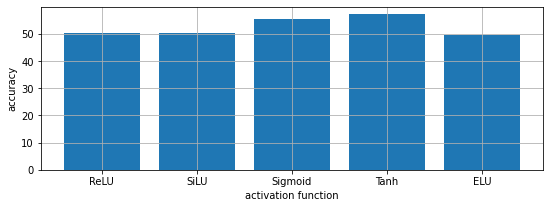

In [8]:
#ENTER CODE HERE
names = ['ReLU', 'SiLU', 'Sigmoid', 'Tanh','ELU']
values = [50.42, 50.42, 55.46, 57.14, 49.58]

plt.figure(figsize=(9, 3))
plt.bar(names, values)
plt.xlabel('activation function')
plt.ylabel('accuracy')
plt.grid(True)
plt.show()

2. **Which function performs better? Justify.**

ANSWER-
Based on my codes and efforts, the Tanh function was the best in case of balanced accuracy. Since the dataset is balanced, we can use this accuracy measure.

We cannot justify the results unless we use a cross-validation method. However, Tanh performs good since it is zero centered, and with its derivative, both are monotonic. Although a downside of using Tanh is the vanishing gradient problem, but since we didn't use a long network, we didn't encounter this problem. I have to mention that the mean of tanh function would be closer to zero compared to the Sigmoid function, and outperforms it. It's a surprise that ReLU was not the best, but it really depends on the type of the network and requires a better assessment to justify.

### **Part II: Custom Activation Functions**

#### **(1) Implement any activation function of your OWN and DO NOT USE any predefined PyTorch Activation Functions [ 3 marks]**



```
class custom_activation_function(nn.Module):
    '''
    Implementation of custom activation function
    '''
    def __init__(self, in_features, alpha = None):
        '''
        Initialization
        '''

    def forward(self, x):
        '''
        Forward pass of the function.
        '''

af = custom_activation_function(<some_parameters>)
x = torch.randn(256) # random tensor
x = af(x)
```

Your Network Architecture should be as follows:

```
Net(
  (cnn_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_2): Sequential(
    (0): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_4): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_5): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_6): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=50176, out_features=4096, bias=True)
  )
  (fully_2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
  )
  (fully_3): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=1000, bias=True)
  )
  (fully_4): Sequential(
    (0): Linear(in_features=1000, out_features=1, bias=True)
  )
  (a1): custom_activation_function()
  (a2): custom_activation_function()
  (a3): custom_activation_function()
)
```

Hint: Here, we are asking you to apply Custom activation functions to the Fully Connected Layers in the forward pass of the Network


In [ ]:
def my_func(x):
  a = x>0
  b = torch.ones(a.shape)
  if torch.cuda.is_available():
    b = b.to("cuda")
  x_np = b * a

  return x_np

In [ ]:
from torch.nn.modules.conv import ConvTranspose2d, Conv2d
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        '''
        Write the 6 CNNs and 4 fully connected CNNs here
        '''
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            # Defining another 2D convolution layer
            Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            
            )
        
        self.First_Dropout = Dropout(p=0.5, inplace=False)
        self.First_linear = Linear(in_features=50176, out_features=4096, bias=True)
        self.Second_Dropout = Dropout(p=0.5, inplace=False)
        self.Second_linear = Linear(in_features=4096, out_features=4096, bias=True)
        self.Third_Dropout = Dropout(p=0.5, inplace=False)
        self.Third_linear = Linear(in_features=4096, out_features=1000, bias=True)
        self.Fourth_linear = Linear(in_features=1000, out_features=1, bias=True)

        self.activation_function = my_func

    def forward(self, x):
        '''
        Define the forward pass : 
        '''
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)

        x = self.First_Dropout(x)
        x = self.First_linear(x)

        x = self.Second_Dropout(x)
        x = self.Second_linear(x)

        x = self.Third_Dropout(x)
        x = self.Third_linear(x)

        x = self.Fourth_linear(x)

        x = self.activation_function(x)
        x = self.activation_function(x)
        x = self.activation_function(x)

        return x
        
'''
DO NOT ALTER THE FOLLOWING CODE
'''
model = Net()
optimizer = Adam(model.parameters(), lr=0.07)
criterion = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)
trained_model = calc_loss(model, n_epochs) #train the model
calc_accuracy(trained_model) # report the accuracy

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

100%|██████████| 34/34 [04:35<00:00,  8.10s/it]


Epoch : 1, train loss : 0.7302287220954895


Epoch : 1, val loss : 0.7034124732017517


100%|██████████| 34/34 [00:03<00:00,  9.58it/s]


Epoch : 2, train loss : 0.7056767344474792


Epoch : 2, val loss : 0.6297773718833923


100%|██████████| 34/34 [00:03<00:00,  9.60it/s]


Epoch : 3, train loss : 0.7154108881950378


Epoch : 3, val loss : 0.7622132301330566


100%|██████████| 34/34 [00:03<00:00,  9.68it/s]


Epoch : 4, train loss : 0.7114231586456299


Epoch : 4, val loss : 0.7154419422149658


100%|██████████| 34/34 [00:03<00:00,  9.68it/s]


Epoch : 5, train loss : 0.7037389874458313


Epoch : 5, val loss : 0.7174227237701416


100%|██████████| 34/34 [00:03<00:00,  9.76it/s]


Epoch : 6, train loss : 0.7136957049369812


Epoch : 6, val loss : 0.6567777395248413


100%|██████████| 34/34 [00:03<00:00,  9.55it/s]


Epoch : 7, train loss : 0.7094559073448181


Epoch : 7, val loss : 0.6754783391952515


100%|██████████| 34/34 [00:04<00:00,  7.56it/s]


Epoch : 8, train loss : 0.7024308443069458


Epoch : 8, val loss : 0.7085803747177124


100%|██████████| 34/34 [00:03<00:00,  9.72it/s]


Epoch : 9, train loss : 0.7378349900245667


Epoch : 9, val loss : 0.6895287036895752


100%|██████████| 34/34 [00:03<00:00,  9.75it/s]


Epoch : 10, train loss : 0.6952624320983887


Epoch : 10, val loss : 0.703814685344696


100%|██████████| 34/34 [00:03<00:00,  9.50it/s]


Epoch : 11, train loss : 0.7180516123771667


Epoch : 11, val loss : 0.6911645531654358


100%|██████████| 34/34 [00:03<00:00,  9.65it/s]


Epoch : 12, train loss : 0.694632887840271


Epoch : 12, val loss : 0.657112181186676


100%|██████████| 34/34 [00:03<00:00,  9.05it/s]


Epoch : 13, train loss : 0.7216880917549133


Epoch : 13, val loss : 0.6980511546134949


100%|██████████| 34/34 [00:04<00:00,  8.11it/s]


Epoch : 14, train loss : 0.7177979946136475


Epoch : 14, val loss : 0.7084528803825378


100%|██████████| 34/34 [00:03<00:00,  9.55it/s]


Epoch : 15, train loss : 0.716200590133667


Epoch : 15, val loss : 0.6886190176010132


100%|██████████| 34/34 [00:05<00:00,  6.62it/s]


Epoch : 16, train loss : 0.7127410769462585


Epoch : 16, val loss : 0.653319239616394


100%|██████████| 34/34 [00:03<00:00,  9.48it/s]


Epoch : 17, train loss : 0.7011634707450867


Epoch : 17, val loss : 0.7538214921951294


100%|██████████| 34/34 [00:03<00:00,  9.52it/s]


Epoch : 18, train loss : 0.7078856825828552


Epoch : 18, val loss : 0.8586421608924866


100%|██████████| 34/34 [00:03<00:00,  9.57it/s]


Epoch : 19, train loss : 0.6946402192115784


Epoch : 19, val loss : 0.7422407865524292


100%|██████████| 34/34 [00:03<00:00,  9.60it/s]


Epoch : 20, train loss : 0.7005096077919006


Epoch : 20, val loss : 0.6743513941764832


100%|██████████| 34/34 [00:03<00:00,  9.77it/s]


Epoch : 21, train loss : 0.7031335830688477


Epoch : 21, val loss : 0.7465473413467407


100%|██████████| 34/34 [00:03<00:00,  9.67it/s]


Epoch : 22, train loss : 0.7011522054672241


Epoch : 22, val loss : 0.6373884081840515


100%|██████████| 34/34 [00:03<00:00,  9.73it/s]


Epoch : 23, train loss : 0.7257386445999146


Epoch : 23, val loss : 0.8077536225318909


100%|██████████| 34/34 [00:04<00:00,  7.58it/s]


Epoch : 24, train loss : 0.7078054547309875


Epoch : 24, val loss : 0.646600604057312


100%|██████████| 34/34 [00:03<00:00,  9.67it/s]


Epoch : 25, train loss : 0.7036476135253906


Epoch : 25, val loss : 0.7562830448150635


100%|██████████| 34/34 [00:03<00:00,  9.66it/s]


Epoch : 26, train loss : 0.6980801820755005


Epoch : 26, val loss : 0.7201275825500488


100%|██████████| 34/34 [00:03<00:00,  9.84it/s]


Epoch : 27, train loss : 0.7098891139030457


Epoch : 27, val loss : 0.749383270740509


100%|██████████| 34/34 [00:03<00:00,  9.51it/s]


Epoch : 28, train loss : 0.7068981528282166


Epoch : 28, val loss : 0.7534744739532471


100%|██████████| 34/34 [00:03<00:00,  9.61it/s]


Epoch : 29, train loss : 0.6982888579368591


Epoch : 29, val loss : 0.7019258737564087


100%|██████████| 34/34 [00:03<00:00,  9.64it/s]


Epoch : 30, train loss : 0.7149412035942078


Epoch : 30, val loss : 0.7610424757003784


100%|██████████| 34/34 [00:03<00:00,  9.63it/s]


Epoch : 31, train loss : 0.706352710723877


Epoch : 31, val loss : 0.713468611240387


100%|██████████| 34/34 [00:03<00:00,  9.64it/s]


Epoch : 32, train loss : 0.709462583065033


Epoch : 32, val loss : 0.6720337271690369


100%|██████████| 34/34 [00:04<00:00,  6.92it/s]


Epoch : 33, train loss : 0.7046592235565186


Epoch : 33, val loss : 0.649808943271637


100%|██████████| 34/34 [00:03<00:00,  9.60it/s]


Epoch : 34, train loss : 0.7096947431564331


Epoch : 34, val loss : 0.6568093299865723


100%|██████████| 34/34 [00:03<00:00,  9.57it/s]


Epoch : 35, train loss : 0.70711749792099


Epoch : 35, val loss : 0.7108442187309265


100%|██████████| 34/34 [00:03<00:00,  9.53it/s]


Epoch : 36, train loss : 0.7022554278373718


Epoch : 36, val loss : 0.7313530445098877


100%|██████████| 34/34 [00:03<00:00,  9.51it/s]


Epoch : 37, train loss : 0.702551007270813


Epoch : 37, val loss : 0.7234916090965271


100%|██████████| 34/34 [00:03<00:00,  9.50it/s]


Epoch : 38, train loss : 0.6977671384811401


Epoch : 38, val loss : 0.6443931460380554


100%|██████████| 34/34 [00:03<00:00,  9.47it/s]


Epoch : 39, train loss : 0.7005791664123535


Epoch : 39, val loss : 0.7547522783279419


100%|██████████| 34/34 [00:03<00:00,  9.39it/s]


Epoch : 40, train loss : 0.6989370584487915


Epoch : 40, val loss : 0.6964040994644165


100%|██████████| 34/34 [00:05<00:00,  6.80it/s]


Epoch : 41, train loss : 0.6961236596107483


Epoch : 41, val loss : 0.7782816886901855


100%|██████████| 34/34 [00:03<00:00,  9.48it/s]


Epoch : 42, train loss : 0.6942369937896729


Epoch : 42, val loss : 0.751917839050293


100%|██████████| 34/34 [00:03<00:00,  9.27it/s]


Epoch : 43, train loss : 0.6958554983139038


Epoch : 43, val loss : 0.7818049788475037


100%|██████████| 34/34 [00:03<00:00,  9.55it/s]


Epoch : 44, train loss : 0.7141985297203064


Epoch : 44, val loss : 0.6718605756759644


100%|██████████| 34/34 [00:03<00:00,  9.60it/s]


Epoch : 45, train loss : 0.7197561860084534


Epoch : 45, val loss : 0.7527788877487183


100%|██████████| 34/34 [00:05<00:00,  6.59it/s]


Epoch : 46, train loss : 0.6965290307998657


Epoch : 46, val loss : 0.7405788898468018


100%|██████████| 34/34 [00:03<00:00,  9.38it/s]


Epoch : 47, train loss : 0.6933518052101135


Epoch : 47, val loss : 0.795259952545166


100%|██████████| 34/34 [00:03<00:00,  9.51it/s]


Epoch : 48, train loss : 0.6876698732376099


Epoch : 48, val loss : 0.7500020861625671


100%|██████████| 34/34 [00:05<00:00,  6.72it/s]


Epoch : 49, train loss : 0.7116789817810059


Epoch : 49, val loss : 0.7108482122421265


100%|██████████| 34/34 [00:03<00:00,  9.55it/s]


Epoch : 50, train loss : 0.7113569378852844


Epoch : 50, val loss : 0.716773509979248
the accuracy is 0.5714285714285714
              precision    recall  f1-score   support

      Adults       0.55      0.81      0.65        59
        Kids       0.65      0.33      0.44        60

    accuracy                           0.57       119
   macro avg       0.60      0.57      0.55       119
weighted avg       0.60      0.57      0.55       119

the balanced accuracy is 0.5734463276836158


0.5714285714285714

#### **(2) Implement any COMPLEX activation function of your OWN and DO NOT USE any predefined PyTorch Activation Functions {CMPUT 566 only} [ 5 marks]**

Implement any one of the following activation functions 

1. [Soft exponential](https://arxiv.org/pdf/1602.01321.pdf)
2. [BReLU](https://arxiv.org/pdf/1709.04054.pdf)





In [ ]:
def BReLU(x):

    x_copy = x.clone()
    evens = [i for i in range(0, x.shape[0], 2)]
    odds = [i for i in range(1, x.shape[0], 2)]

    x_copy[evens] = x_copy[evens]*(x_copy[evens]>0)
    x_copy[odds] = - x_copy[odds] 
    x_copy[odds] = - (x_copy[odds]*(x_copy[odds]>0))

    return x_copy

In [ ]:
from torch.nn.modules.conv import ConvTranspose2d, Conv2d
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        '''
        Write the 6 CNNs and 4 fully connected CNNs here
        '''
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            # Defining another 2D convolution layer
            Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            
            )
        
        self.First_Dropout = Dropout(p=0.5, inplace=False)
        self.First_linear = Linear(in_features=50176, out_features=4096, bias=True)
        self.Second_Dropout = Dropout(p=0.5, inplace=False)
        self.Second_linear = Linear(in_features=4096, out_features=4096, bias=True)
        self.Third_Dropout = Dropout(p=0.5, inplace=False)
        self.Third_linear = Linear(in_features=4096, out_features=1000, bias=True)
        self.Fourth_linear = Linear(in_features=1000, out_features=1, bias=True)

        self.activation_function = BReLU

    def forward(self, x):
        '''
        Define the forward pass : 
        '''
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)

        x = self.First_Dropout(x)
        x = self.First_linear(x)

        x = self.Second_Dropout(x)
        x = self.Second_linear(x)

        x = self.Third_Dropout(x)
        x = self.Third_linear(x)

        x = self.Fourth_linear(x)

        x = self.activation_function(x)
        x = self.activation_function(x)
        x = self.activation_function(x)

        return x
        
'''
DO NOT ALTER THE FOLLOWING CODE
'''
model = Net()
optimizer = Adam(model.parameters(), lr=0.07)
criterion = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)
trained_model = calc_loss(model, n_epochs) #train the model
calc_accuracy(trained_model) # report the accuracy

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

100%|██████████| 34/34 [00:08<00:00,  3.87it/s]


Epoch : 1, train loss : 85.93445587158203


Epoch : 1, val loss : 94.56427764892578


100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


Epoch : 2, train loss : 15.797348976135254


Epoch : 2, val loss : 22.81747055053711


100%|██████████| 34/34 [00:08<00:00,  3.91it/s]


Epoch : 3, train loss : 16.885482788085938


Epoch : 3, val loss : 14.261885643005371


100%|██████████| 34/34 [00:08<00:00,  3.86it/s]


Epoch : 4, train loss : 4.673673629760742


Epoch : 4, val loss : 5.147424697875977


100%|██████████| 34/34 [00:08<00:00,  3.86it/s]


Epoch : 5, train loss : 2.657351493835449


Epoch : 5, val loss : 0.902996301651001


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 6, train loss : 1.8083627223968506


Epoch : 6, val loss : 0.43735912442207336


100%|██████████| 34/34 [00:09<00:00,  3.70it/s]


Epoch : 7, train loss : 1.251448154449463


Epoch : 7, val loss : 1.0923584699630737


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 8, train loss : 1.2339991331100464


Epoch : 8, val loss : 1.2822060585021973


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 9, train loss : 1.3712440729141235


Epoch : 9, val loss : 2.1870815753936768


100%|██████████| 34/34 [00:09<00:00,  3.73it/s]


Epoch : 10, train loss : 2.007326126098633


Epoch : 10, val loss : 1.9118772745132446


100%|██████████| 34/34 [00:08<00:00,  3.78it/s]


Epoch : 11, train loss : 1.9093748331069946


Epoch : 11, val loss : 3.7609567642211914


100%|██████████| 34/34 [00:09<00:00,  3.64it/s]


Epoch : 12, train loss : 1.6162292957305908


Epoch : 12, val loss : 0.7784109711647034


100%|██████████| 34/34 [00:09<00:00,  3.63it/s]


Epoch : 13, train loss : 1.253210425376892


Epoch : 13, val loss : 1.0045839548110962


100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


Epoch : 14, train loss : 1.2558828592300415


Epoch : 14, val loss : 0.6291689276695251


100%|██████████| 34/34 [00:09<00:00,  3.75it/s]


Epoch : 15, train loss : 1.2335761785507202


Epoch : 15, val loss : 0.6973073482513428


100%|██████████| 34/34 [00:09<00:00,  3.76it/s]


Epoch : 16, train loss : 1.5057517290115356


Epoch : 16, val loss : 1.2305302619934082


100%|██████████| 34/34 [00:09<00:00,  3.59it/s]


Epoch : 17, train loss : 1.479587435722351


Epoch : 17, val loss : 1.6904395818710327


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


Epoch : 18, train loss : 1.5058834552764893


Epoch : 18, val loss : 0.7024200558662415


100%|██████████| 34/34 [00:09<00:00,  3.70it/s]


Epoch : 19, train loss : 1.356116533279419


Epoch : 19, val loss : 1.2991347312927246


100%|██████████| 34/34 [00:09<00:00,  3.72it/s]


Epoch : 20, train loss : 1.0968022346496582


Epoch : 20, val loss : 0.7817012667655945


100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


Epoch : 21, train loss : 1.9374018907546997


Epoch : 21, val loss : 0.8670610189437866


100%|██████████| 34/34 [00:09<00:00,  3.67it/s]


Epoch : 22, train loss : 2.0605316162109375


Epoch : 22, val loss : 3.3266983032226562


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


Epoch : 23, train loss : 2.6396639347076416


Epoch : 23, val loss : 2.5821785926818848


100%|██████████| 34/34 [00:09<00:00,  3.75it/s]


Epoch : 24, train loss : 1.9912605285644531


Epoch : 24, val loss : 3.188149929046631


100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


Epoch : 25, train loss : 2.488269090652466


Epoch : 25, val loss : 5.500767230987549


100%|██████████| 34/34 [00:09<00:00,  3.64it/s]


Epoch : 26, train loss : 2.003411293029785


Epoch : 26, val loss : 2.545224189758301


100%|██████████| 34/34 [00:09<00:00,  3.72it/s]


Epoch : 27, train loss : 2.9184157848358154


Epoch : 27, val loss : 3.438715934753418


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


Epoch : 28, train loss : 7.426496982574463


Epoch : 28, val loss : 11.365928649902344


100%|██████████| 34/34 [00:09<00:00,  3.73it/s]


Epoch : 29, train loss : 38.01918029785156


Epoch : 29, val loss : 153.95608520507812


100%|██████████| 34/34 [00:09<00:00,  3.75it/s]


Epoch : 30, train loss : 3564.68701171875


Epoch : 30, val loss : 5419.11572265625


100%|██████████| 34/34 [00:09<00:00,  3.56it/s]


Epoch : 31, train loss : 1742.95849609375


Epoch : 31, val loss : 647.6365966796875


100%|██████████| 34/34 [00:09<00:00,  3.73it/s]


Epoch : 32, train loss : 604.0396728515625


Epoch : 32, val loss : 406.5532531738281


100%|██████████| 34/34 [00:09<00:00,  3.76it/s]


Epoch : 33, train loss : 923.4932250976562


Epoch : 33, val loss : 1211.7789306640625


100%|██████████| 34/34 [00:09<00:00,  3.73it/s]


Epoch : 34, train loss : 546.76123046875


Epoch : 34, val loss : 105.90572357177734


100%|██████████| 34/34 [00:09<00:00,  3.70it/s]


Epoch : 35, train loss : 130.71043395996094


Epoch : 35, val loss : 117.54298400878906


100%|██████████| 34/34 [00:09<00:00,  3.61it/s]


Epoch : 36, train loss : 74.62939453125


Epoch : 36, val loss : 121.8265609741211


100%|██████████| 34/34 [00:09<00:00,  3.63it/s]



Epoch : 37, train loss : 72.95844268798828
Epoch : 37, val loss : 20.604028701782227


100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


Epoch : 38, train loss : 56.15195083618164


Epoch : 38, val loss : 40.522003173828125


100%|██████████| 34/34 [00:09<00:00,  3.73it/s]


Epoch : 39, train loss : 47.17532730102539


Epoch : 39, val loss : 24.320035934448242


100%|██████████| 34/34 [00:09<00:00,  3.63it/s]


Epoch : 40, train loss : 22.560447692871094


Epoch : 40, val loss : 39.04074478149414


100%|██████████| 34/34 [00:09<00:00,  3.70it/s]


Epoch : 41, train loss : 17.137767791748047


Epoch : 41, val loss : 28.643007278442383


100%|██████████| 34/34 [00:09<00:00,  3.73it/s]


Epoch : 42, train loss : 29.798559188842773


Epoch : 42, val loss : 12.047711372375488


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


Epoch : 43, train loss : 18.592838287353516


Epoch : 43, val loss : 22.665729522705078


100%|██████████| 34/34 [00:09<00:00,  3.73it/s]


Epoch : 44, train loss : 18.651729583740234


Epoch : 44, val loss : 18.68752670288086


100%|██████████| 34/34 [00:09<00:00,  3.55it/s]


Epoch : 45, train loss : 12.767687797546387


Epoch : 45, val loss : 2.4000253677368164


100%|██████████| 34/34 [00:09<00:00,  3.58it/s]


Epoch : 46, train loss : 19.52604103088379


Epoch : 46, val loss : 46.72084045410156


100%|██████████| 34/34 [00:09<00:00,  3.73it/s]


Epoch : 47, train loss : 19.556180953979492


Epoch : 47, val loss : 17.167509078979492


100%|██████████| 34/34 [00:09<00:00,  3.73it/s]


Epoch : 48, train loss : 15.36434268951416


Epoch : 48, val loss : 15.43932819366455


100%|██████████| 34/34 [00:09<00:00,  3.67it/s]


Epoch : 49, train loss : 13.940804481506348


Epoch : 49, val loss : 8.147894859313965


100%|██████████| 34/34 [00:09<00:00,  3.41it/s]


Epoch : 50, train loss : 10.96005630493164


Epoch : 50, val loss : 12.829440116882324
the accuracy is 0.5042016806722689
              precision    recall  f1-score   support

      Adults       0.00      0.00      0.00        59
        Kids       0.50      1.00      0.67        60

    accuracy                           0.50       119
   macro avg       0.25      0.50      0.34       119
weighted avg       0.25      0.50      0.34       119

the balanced accuracy is 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5042016806722689

### **Part III: ResNet [6 marks]**

#### **(1) Implement the following **pretrained ResNet variants****


1. ResNet18
2. ResNet50
3. ResNet152

You can refer the ResNet documentation in the RESOURCES tab.


In [ ]:
model_resnet_variant = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

'''
DO NOT ALTER THE FOLLOWING CODE
'''
#freeze all the model parameters
for params in model_resnet_variant.parameters():
  params.requires_grad_ = False
'''
DO NOT ALTER THE ABOVE CODE
'''

nr_filters = 512 #ENTER CODE HERE
model_resnet_variant.fc = nn.Linear(nr_filters, 1)
model_resnet_variant = model_resnet_variant.to(device)

trained_model = calc_loss(model_resnet_variant, n_epochs)
calc_accuracy(trained_model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
100%|██████████| 34/34 [00:04<00:00,  8.00it/s]


Epoch : 1, train loss : 0.6947041749954224


Epoch : 1, val loss : 0.5626654624938965


100%|██████████| 34/34 [00:04<00:00,  8.07it/s]


Epoch : 2, train loss : 0.5174733996391296


Epoch : 2, val loss : 0.40234455466270447


100%|██████████| 34/34 [00:04<00:00,  8.03it/s]


Epoch : 3, train loss : 0.3565727174282074


Epoch : 3, val loss : 0.2390638291835785


100%|██████████| 34/34 [00:04<00:00,  7.96it/s]


Epoch : 4, train loss : 0.4371556043624878


Epoch : 4, val loss : 0.4574773609638214


100%|██████████| 34/34 [00:05<00:00,  6.01it/s]


Epoch : 5, train loss : 0.3410909175872803


Epoch : 5, val loss : 0.11718717962503433


100%|██████████| 34/34 [00:04<00:00,  7.88it/s]


Epoch : 6, train loss : 0.2442898154258728


Epoch : 6, val loss : 0.22630751132965088


100%|██████████| 34/34 [00:04<00:00,  8.08it/s]


Epoch : 7, train loss : 0.20576545596122742


Epoch : 7, val loss : 0.14749696850776672


100%|██████████| 34/34 [00:04<00:00,  7.98it/s]


Epoch : 8, train loss : 0.19830980896949768


Epoch : 8, val loss : 0.16820812225341797


100%|██████████| 34/34 [00:04<00:00,  8.04it/s]


Epoch : 9, train loss : 0.08497263491153717


Epoch : 9, val loss : 0.045324355363845825


100%|██████████| 34/34 [00:04<00:00,  7.84it/s]


Epoch : 10, train loss : 0.22263020277023315


Epoch : 10, val loss : 0.5208315849304199


100%|██████████| 34/34 [00:04<00:00,  7.96it/s]


Epoch : 11, train loss : 0.23511384427547455


Epoch : 11, val loss : 0.17776092886924744


100%|██████████| 34/34 [00:04<00:00,  7.87it/s]


Epoch : 12, train loss : 0.15334007143974304


Epoch : 12, val loss : 0.10301045328378677


100%|██████████| 34/34 [00:04<00:00,  7.83it/s]


Epoch : 13, train loss : 0.17983834445476532


Epoch : 13, val loss : 0.0792018324136734


100%|██████████| 34/34 [00:06<00:00,  5.61it/s]


Epoch : 14, train loss : 0.1597060263156891


Epoch : 14, val loss : 0.02684592455625534


100%|██████████| 34/34 [00:04<00:00,  7.78it/s]


Epoch : 15, train loss : 0.14680615067481995


Epoch : 15, val loss : 0.06492217630147934


100%|██████████| 34/34 [00:04<00:00,  7.95it/s]


Epoch : 16, train loss : 0.13918563723564148


Epoch : 16, val loss : 0.11106179654598236


100%|██████████| 34/34 [00:04<00:00,  7.81it/s]


Epoch : 17, train loss : 0.1008635014295578


Epoch : 17, val loss : 0.022226931527256966


100%|██████████| 34/34 [00:04<00:00,  7.90it/s]


Epoch : 18, train loss : 0.10603159666061401


Epoch : 18, val loss : 0.45681190490722656


100%|██████████| 34/34 [00:04<00:00,  7.82it/s]


Epoch : 19, train loss : 0.08334541320800781


Epoch : 19, val loss : 0.018632596358656883


100%|██████████| 34/34 [00:04<00:00,  7.96it/s]


Epoch : 20, train loss : 0.04575874283909798


Epoch : 20, val loss : 0.01632869429886341


100%|██████████| 34/34 [00:04<00:00,  7.83it/s]


Epoch : 21, train loss : 0.04198211058974266


Epoch : 21, val loss : 0.02485053986310959


100%|██████████| 34/34 [00:04<00:00,  7.77it/s]


Epoch : 22, train loss : 0.09444405883550644


Epoch : 22, val loss : 0.022228574380278587


100%|██████████| 34/34 [00:06<00:00,  5.58it/s]


Epoch : 23, train loss : 0.09616867452859879


Epoch : 23, val loss : 0.036514319479465485


100%|██████████| 34/34 [00:04<00:00,  7.66it/s]


Epoch : 24, train loss : 0.045163679867982864


Epoch : 24, val loss : 0.01645466312766075


100%|██████████| 34/34 [00:04<00:00,  7.87it/s]


Epoch : 25, train loss : 0.01060680951923132


Epoch : 25, val loss : 0.0021387680899351835


100%|██████████| 34/34 [00:04<00:00,  7.97it/s]


Epoch : 26, train loss : 0.005915217567235231


Epoch : 26, val loss : 0.0013979315990582108


100%|██████████| 34/34 [00:04<00:00,  7.95it/s]


Epoch : 27, train loss : 0.00189599534496665


Epoch : 27, val loss : 0.005552258342504501


100%|██████████| 34/34 [00:04<00:00,  8.05it/s]


Epoch : 28, train loss : 0.0026209268253296614


Epoch : 28, val loss : 0.001567702041938901


100%|██████████| 34/34 [00:04<00:00,  7.89it/s]


Epoch : 29, train loss : 0.002216261811554432


Epoch : 29, val loss : 0.0003689875593408942


100%|██████████| 34/34 [00:04<00:00,  7.89it/s]


Epoch : 30, train loss : 0.02503831312060356


Epoch : 30, val loss : 0.0014278655871748924


100%|██████████| 34/34 [00:06<00:00,  5.13it/s]


Epoch : 31, train loss : 0.05747558921575546


Epoch : 31, val loss : 0.029578229412436485


100%|██████████| 34/34 [00:04<00:00,  7.80it/s]


Epoch : 32, train loss : 0.06804317981004715


Epoch : 32, val loss : 0.10598741471767426


100%|██████████| 34/34 [00:04<00:00,  7.74it/s]


Epoch : 33, train loss : 0.028987210243940353


Epoch : 33, val loss : 0.008992408402264118


100%|██████████| 34/34 [00:04<00:00,  7.75it/s]


Epoch : 34, train loss : 0.03183359280228615


Epoch : 34, val loss : 0.039696104824543


100%|██████████| 34/34 [00:04<00:00,  7.88it/s]


Epoch : 35, train loss : 0.044758476316928864


Epoch : 35, val loss : 0.017894892022013664


100%|██████████| 34/34 [00:04<00:00,  7.89it/s]


Epoch : 36, train loss : 0.021955581381917


Epoch : 36, val loss : 0.003128673415631056


100%|██████████| 34/34 [00:04<00:00,  8.03it/s]


Epoch : 37, train loss : 0.03837317228317261


Epoch : 37, val loss : 0.016442377120256424


100%|██████████| 34/34 [00:04<00:00,  7.97it/s]


Epoch : 38, train loss : 0.018839409574866295


Epoch : 38, val loss : 0.0006054205005057156


100%|██████████| 34/34 [00:04<00:00,  8.01it/s]


Epoch : 39, train loss : 0.020620405673980713


Epoch : 39, val loss : 0.039809197187423706


100%|██████████| 34/34 [00:06<00:00,  5.62it/s]


Epoch : 40, train loss : 0.09467177838087082


Epoch : 40, val loss : 0.2055031806230545


100%|██████████| 34/34 [00:04<00:00,  8.10it/s]


Epoch : 41, train loss : 0.22025780379772186


Epoch : 41, val loss : 0.14168646931648254


100%|██████████| 34/34 [00:04<00:00,  8.27it/s]


Epoch : 42, train loss : 0.08100398629903793


Epoch : 42, val loss : 0.10083577036857605


100%|██████████| 34/34 [00:04<00:00,  8.44it/s]


Epoch : 43, train loss : 0.010623877868056297


Epoch : 43, val loss : 0.011014021001756191


100%|██████████| 34/34 [00:04<00:00,  8.28it/s]


Epoch : 44, train loss : 0.006972185336053371


Epoch : 44, val loss : 0.0010603333357721567


100%|██████████| 34/34 [00:04<00:00,  8.13it/s]


Epoch : 45, train loss : 0.007095981389284134


Epoch : 45, val loss : 0.01478629931807518


100%|██████████| 34/34 [00:04<00:00,  8.29it/s]


Epoch : 46, train loss : 0.0014366944087669253


Epoch : 46, val loss : 0.0023078268859535456


100%|██████████| 34/34 [00:04<00:00,  8.19it/s]


Epoch : 47, train loss : 0.0024302673991769552


Epoch : 47, val loss : 0.00036070041824132204


100%|██████████| 34/34 [00:04<00:00,  8.29it/s]


Epoch : 48, train loss : 0.0016170800663530827


Epoch : 48, val loss : 0.0002222525654360652


100%|██████████| 34/34 [00:05<00:00,  5.77it/s]


Epoch : 49, train loss : 0.019875988364219666


Epoch : 49, val loss : 0.19051824510097504


100%|██████████| 34/34 [00:03<00:00,  8.55it/s]


Epoch : 50, train loss : 0.009608306922018528


Epoch : 50, val loss : 0.0010098920902237296
the accuracy is 0.7394957983193278
              precision    recall  f1-score   support

      Adults       0.70      0.83      0.76        59
        Kids       0.80      0.65      0.72        60

    accuracy                           0.74       119
   macro avg       0.75      0.74      0.74       119
weighted avg       0.75      0.74      0.74       119

the balanced accuracy is 0.7402542372881356


0.7394957983193278

In [ ]:
model_resnet_variant = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

'''
DO NOT ALTER THE FOLLOWING CODE
'''
#freeze all the model parameters
for params in model_resnet_variant.parameters():
  params.requires_grad_ = False
'''
DO NOT ALTER THE ABOVE CODE
'''

nr_filters = 2048 #ENTER CODE HERE
model_resnet_variant.fc = nn.Linear(nr_filters, 1)
model_resnet_variant = model_resnet_variant.to(device)

trained_model = calc_loss(model_resnet_variant, n_epochs)
calc_accuracy(trained_model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
100%|██████████| 34/34 [00:06<00:00,  5.19it/s]


Epoch : 1, train loss : 0.7063872814178467


Epoch : 1, val loss : 0.46562445163726807


100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


Epoch : 2, train loss : 0.704118549823761


Epoch : 2, val loss : 0.7523404359817505


100%|██████████| 34/34 [00:06<00:00,  5.57it/s]


Epoch : 3, train loss : 0.9931662678718567


Epoch : 3, val loss : 0.7256208658218384


100%|██████████| 34/34 [00:06<00:00,  5.55it/s]


Epoch : 4, train loss : 0.8500532507896423


Epoch : 4, val loss : 0.810343861579895


100%|██████████| 34/34 [00:06<00:00,  5.49it/s]


Epoch : 5, train loss : 0.6519516706466675


Epoch : 5, val loss : 0.6103231906890869


100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


Epoch : 6, train loss : 0.605789065361023


Epoch : 6, val loss : 0.6217830777168274


100%|██████████| 34/34 [00:07<00:00,  4.81it/s]


Epoch : 7, train loss : 0.6197894811630249


Epoch : 7, val loss : 0.6020156145095825


100%|██████████| 34/34 [00:07<00:00,  4.60it/s]


Epoch : 8, train loss : 0.5732040405273438


Epoch : 8, val loss : 0.55096435546875


100%|██████████| 34/34 [00:06<00:00,  5.51it/s]


Epoch : 9, train loss : 0.5586632490158081


Epoch : 9, val loss : 0.6452873945236206


100%|██████████| 34/34 [00:06<00:00,  5.50it/s]


Epoch : 10, train loss : 0.5188111066818237


Epoch : 10, val loss : 0.39270246028900146


100%|██████████| 34/34 [00:06<00:00,  5.49it/s]


Epoch : 11, train loss : 0.4846404492855072


Epoch : 11, val loss : 0.45190614461898804


100%|██████████| 34/34 [00:06<00:00,  5.41it/s]


Epoch : 12, train loss : 0.42537420988082886


Epoch : 12, val loss : 0.4122622013092041


100%|██████████| 34/34 [00:06<00:00,  5.41it/s]


Epoch : 13, train loss : 0.5637506246566772


Epoch : 13, val loss : 0.5569912195205688


100%|██████████| 34/34 [00:07<00:00,  4.82it/s]


Epoch : 14, train loss : 0.43179959058761597


Epoch : 14, val loss : 0.6927673816680908


100%|██████████| 34/34 [00:06<00:00,  5.38it/s]


Epoch : 15, train loss : 0.37031230330467224


Epoch : 15, val loss : 0.3256695568561554


100%|██████████| 34/34 [00:06<00:00,  5.37it/s]


Epoch : 16, train loss : 0.503330647945404


Epoch : 16, val loss : 0.7972877025604248


100%|██████████| 34/34 [00:06<00:00,  5.41it/s]


Epoch : 17, train loss : 0.5207996368408203


Epoch : 17, val loss : 0.32738980650901794


100%|██████████| 34/34 [00:06<00:00,  5.39it/s]


Epoch : 18, train loss : 0.2717994451522827


Epoch : 18, val loss : 0.4180174469947815


100%|██████████| 34/34 [00:06<00:00,  5.44it/s]


Epoch : 19, train loss : 0.2544485330581665


Epoch : 19, val loss : 0.11443401873111725


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


Epoch : 20, train loss : 0.3338378667831421


Epoch : 20, val loss : 0.24180178344249725


100%|██████████| 34/34 [00:06<00:00,  5.08it/s]


Epoch : 21, train loss : 1.1873953342437744


Epoch : 21, val loss : 0.7646980285644531


100%|██████████| 34/34 [00:06<00:00,  5.42it/s]


Epoch : 22, train loss : 0.6903942823410034


Epoch : 22, val loss : 0.683445155620575


100%|██████████| 34/34 [00:06<00:00,  5.37it/s]


Epoch : 23, train loss : 0.6054925918579102


Epoch : 23, val loss : 0.6763456463813782


100%|██████████| 34/34 [00:06<00:00,  5.36it/s]


Epoch : 24, train loss : 0.5041574835777283


Epoch : 24, val loss : 0.18082408607006073


100%|██████████| 34/34 [00:06<00:00,  5.25it/s]


Epoch : 25, train loss : 0.38902363181114197


Epoch : 25, val loss : 0.4416637718677521


100%|██████████| 34/34 [00:07<00:00,  4.66it/s]


Epoch : 26, train loss : 0.31879138946533203


Epoch : 26, val loss : 0.2919941544532776


100%|██████████| 34/34 [00:08<00:00,  3.94it/s]


Epoch : 27, train loss : 0.3112562894821167


Epoch : 27, val loss : 0.12325620651245117


100%|██████████| 34/34 [00:07<00:00,  4.58it/s]


Epoch : 28, train loss : 0.4546903371810913


Epoch : 28, val loss : 0.46337059140205383


100%|██████████| 34/34 [00:07<00:00,  4.56it/s]


Epoch : 29, train loss : 0.2844884693622589


Epoch : 29, val loss : 0.23203091323375702


100%|██████████| 34/34 [00:07<00:00,  4.47it/s]


Epoch : 30, train loss : 0.21484550833702087


Epoch : 30, val loss : 0.49398183822631836


100%|██████████| 34/34 [00:09<00:00,  3.67it/s]


Epoch : 31, train loss : 0.21380853652954102


Epoch : 31, val loss : 0.1285848468542099


100%|██████████| 34/34 [00:07<00:00,  4.42it/s]


Epoch : 32, train loss : 0.12041227519512177


Epoch : 32, val loss : 0.02091319113969803


100%|██████████| 34/34 [00:07<00:00,  4.53it/s]


Epoch : 33, train loss : 0.2549801170825958


Epoch : 33, val loss : 0.536041259765625


100%|██████████| 34/34 [00:07<00:00,  4.68it/s]


Epoch : 34, train loss : 0.45912879705429077


Epoch : 34, val loss : 0.425567090511322


100%|██████████| 34/34 [00:07<00:00,  4.70it/s]


Epoch : 35, train loss : 0.358646035194397


Epoch : 35, val loss : 0.03278306871652603


100%|██████████| 34/34 [00:07<00:00,  4.62it/s]


Epoch : 36, train loss : 0.20874857902526855


Epoch : 36, val loss : 0.26644885540008545


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 37, train loss : 0.19643929600715637


Epoch : 37, val loss : 0.28892752528190613


100%|██████████| 34/34 [00:07<00:00,  4.65it/s]


Epoch : 38, train loss : 0.31580230593681335


Epoch : 38, val loss : 0.16731449961662292


100%|██████████| 34/34 [00:07<00:00,  4.75it/s]


Epoch : 39, train loss : 0.2651935815811157


Epoch : 39, val loss : 0.10347715020179749


100%|██████████| 34/34 [00:07<00:00,  4.73it/s]


Epoch : 40, train loss : 0.1567973792552948


Epoch : 40, val loss : 0.06479958444833755


100%|██████████| 34/34 [00:07<00:00,  4.77it/s]


Epoch : 41, train loss : 0.12819069623947144


Epoch : 41, val loss : 0.12836702167987823


100%|██████████| 34/34 [00:08<00:00,  4.20it/s]


Epoch : 42, train loss : 0.21564744412899017


Epoch : 42, val loss : 0.11000697314739227


100%|██████████| 34/34 [00:07<00:00,  4.62it/s]


Epoch : 43, train loss : 0.16612930595874786


Epoch : 43, val loss : 0.06829213351011276


100%|██████████| 34/34 [00:07<00:00,  4.71it/s]


Epoch : 44, train loss : 0.1925380975008011


Epoch : 44, val loss : 0.02443777024745941


100%|██████████| 34/34 [00:07<00:00,  4.63it/s]


Epoch : 45, train loss : 0.12095416337251663


Epoch : 45, val loss : 0.10721816122531891


100%|██████████| 34/34 [00:07<00:00,  4.78it/s]


Epoch : 46, train loss : 0.11778729408979416


Epoch : 46, val loss : 0.26210179924964905


100%|██████████| 34/34 [00:07<00:00,  4.81it/s]


Epoch : 47, train loss : 0.050890546292066574


Epoch : 47, val loss : 0.040519796311855316


100%|██████████| 34/34 [00:08<00:00,  3.89it/s]


Epoch : 48, train loss : 0.024928836151957512


Epoch : 48, val loss : 0.007248141802847385


100%|██████████| 34/34 [00:06<00:00,  4.86it/s]


Epoch : 49, train loss : 0.09164624661207199


Epoch : 49, val loss : 0.018315207213163376


100%|██████████| 34/34 [00:07<00:00,  4.73it/s]


Epoch : 50, train loss : 0.038136158138513565


Epoch : 50, val loss : 0.00500827981159091
the accuracy is 0.6722689075630253
              precision    recall  f1-score   support

      Adults       0.66      0.71      0.68        59
        Kids       0.69      0.63      0.66        60

    accuracy                           0.67       119
   macro avg       0.67      0.67      0.67       119
weighted avg       0.67      0.67      0.67       119

the balanced accuracy is 0.6725988700564971


0.6722689075630253

In [ ]:
model_resnet_variant = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)

'''
DO NOT ALTER THE FOLLOWING CODE
'''
#freeze all the model parameters
for params in model_resnet_variant.parameters():
  params.requires_grad_ = False
'''
DO NOT ALTER THE ABOVE CODE
'''

nr_filters = 2048 #ENTER CODE HERE
model_resnet_variant.fc = nn.Linear(nr_filters, 1)
model_resnet_variant = model_resnet_variant.to(device)

trained_model = calc_loss(model_resnet_variant, n_epochs)
calc_accuracy(trained_model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
100%|██████████| 34/34 [00:13<00:00,  2.48it/s]


Epoch : 1, train loss : 0.7417643666267395


Epoch : 1, val loss : 0.7134261131286621


100%|██████████| 34/34 [00:13<00:00,  2.51it/s]


Epoch : 2, train loss : 1.844099760055542


Epoch : 2, val loss : 0.6280622482299805


100%|██████████| 34/34 [00:13<00:00,  2.43it/s]


Epoch : 3, train loss : 0.7374510765075684


Epoch : 3, val loss : 0.7019371390342712


100%|██████████| 34/34 [00:13<00:00,  2.46it/s]


Epoch : 4, train loss : 0.7162203192710876


Epoch : 4, val loss : 0.6548214554786682


100%|██████████| 34/34 [00:13<00:00,  2.44it/s]


Epoch : 5, train loss : 0.6825004816055298


Epoch : 5, val loss : 0.7570975422859192


100%|██████████| 34/34 [00:13<00:00,  2.43it/s]


Epoch : 6, train loss : 0.6597463488578796


Epoch : 6, val loss : 0.6385520696640015


100%|██████████| 34/34 [00:14<00:00,  2.39it/s]


Epoch : 7, train loss : 0.6991170644760132


Epoch : 7, val loss : 0.7417112588882446


100%|██████████| 34/34 [00:14<00:00,  2.42it/s]


Epoch : 8, train loss : 0.6403476595878601


Epoch : 8, val loss : 0.7242466807365417


100%|██████████| 34/34 [00:14<00:00,  2.37it/s]


Epoch : 9, train loss : 0.6311637759208679


Epoch : 9, val loss : 0.5914595127105713


100%|██████████| 34/34 [00:14<00:00,  2.35it/s]


Epoch : 10, train loss : 0.6224606037139893


Epoch : 10, val loss : 0.5541283488273621


100%|██████████| 34/34 [00:13<00:00,  2.43it/s]


Epoch : 11, train loss : 0.5944768190383911


Epoch : 11, val loss : 0.6183038353919983


100%|██████████| 34/34 [00:13<00:00,  2.43it/s]


Epoch : 12, train loss : 0.6067978143692017


Epoch : 12, val loss : 0.4774973392486572


100%|██████████| 34/34 [00:14<00:00,  2.39it/s]


Epoch : 13, train loss : 0.5424042344093323


Epoch : 13, val loss : 0.4130464494228363


100%|██████████| 34/34 [00:13<00:00,  2.43it/s]


Epoch : 14, train loss : 0.5593542456626892


Epoch : 14, val loss : 0.3151609003543854


100%|██████████| 34/34 [00:14<00:00,  2.41it/s]


Epoch : 15, train loss : 0.60592120885849


Epoch : 15, val loss : 0.5627095699310303


100%|██████████| 34/34 [00:14<00:00,  2.39it/s]


Epoch : 16, train loss : 11.746197700500488


Epoch : 16, val loss : 0.7301459312438965


100%|██████████| 34/34 [00:14<00:00,  2.41it/s]


Epoch : 17, train loss : 71.51970672607422


Epoch : 17, val loss : 1.1086952686309814


100%|██████████| 34/34 [00:14<00:00,  2.39it/s]


Epoch : 18, train loss : 0.7237206101417542


Epoch : 18, val loss : 0.7907683849334717


100%|██████████| 34/34 [00:14<00:00,  2.29it/s]


Epoch : 19, train loss : 0.6790206432342529


Epoch : 19, val loss : 0.5359676480293274


100%|██████████| 34/34 [00:14<00:00,  2.39it/s]


Epoch : 20, train loss : 0.6374890804290771


Epoch : 20, val loss : 0.534709095954895


100%|██████████| 34/34 [00:14<00:00,  2.30it/s]


Epoch : 21, train loss : 0.6394007802009583


Epoch : 21, val loss : 0.5140858888626099


100%|██████████| 34/34 [00:14<00:00,  2.30it/s]


Epoch : 22, train loss : 0.6253498792648315


Epoch : 22, val loss : 0.59033203125


100%|██████████| 34/34 [00:14<00:00,  2.38it/s]


Epoch : 23, train loss : 0.5917909145355225


Epoch : 23, val loss : 0.6471202373504639


100%|██████████| 34/34 [00:14<00:00,  2.39it/s]


Epoch : 24, train loss : 0.589779257774353


Epoch : 24, val loss : 0.5410618782043457


100%|██████████| 34/34 [00:14<00:00,  2.30it/s]


Epoch : 25, train loss : 0.633752167224884


Epoch : 25, val loss : 0.8131894469261169


100%|██████████| 34/34 [00:14<00:00,  2.40it/s]


Epoch : 26, train loss : 0.5707423090934753


Epoch : 26, val loss : 0.49591708183288574


100%|██████████| 34/34 [00:14<00:00,  2.38it/s]


Epoch : 27, train loss : 0.5461243391036987


Epoch : 27, val loss : 0.5408817529678345


100%|██████████| 34/34 [00:14<00:00,  2.36it/s]



Epoch : 28, train loss : 0.6008149981498718
Epoch : 28, val loss : 0.7412683963775635


100%|██████████| 34/34 [00:14<00:00,  2.39it/s]


Epoch : 29, train loss : 0.5913845300674438


Epoch : 29, val loss : 0.6693737506866455


100%|██████████| 34/34 [00:14<00:00,  2.39it/s]


Epoch : 30, train loss : 0.561123251914978


Epoch : 30, val loss : 0.3991379141807556


100%|██████████| 34/34 [00:14<00:00,  2.38it/s]


Epoch : 31, train loss : 0.5648753046989441


Epoch : 31, val loss : 0.4801228642463684


100%|██████████| 34/34 [00:14<00:00,  2.35it/s]


Epoch : 32, train loss : 0.5476332902908325


Epoch : 32, val loss : 0.5372926592826843


100%|██████████| 34/34 [00:14<00:00,  2.38it/s]


Epoch : 33, train loss : 0.5688656568527222


Epoch : 33, val loss : 0.7304449677467346


100%|██████████| 34/34 [00:14<00:00,  2.38it/s]


Epoch : 34, train loss : 0.5518715977668762


Epoch : 34, val loss : 0.5956610441207886


100%|██████████| 34/34 [00:14<00:00,  2.40it/s]


Epoch : 35, train loss : 0.5787768959999084


Epoch : 35, val loss : 0.404294490814209


100%|██████████| 34/34 [00:14<00:00,  2.39it/s]


Epoch : 36, train loss : 0.5372779369354248


Epoch : 36, val loss : 0.266705185174942


100%|██████████| 34/34 [00:14<00:00,  2.39it/s]


Epoch : 37, train loss : 0.5076218843460083


Epoch : 37, val loss : 0.5592628121376038


100%|██████████| 34/34 [00:14<00:00,  2.34it/s]


Epoch : 38, train loss : 0.4939836263656616


Epoch : 38, val loss : 0.8403354287147522


100%|██████████| 34/34 [00:14<00:00,  2.40it/s]


Epoch : 39, train loss : 0.6180247068405151


Epoch : 39, val loss : 0.40233615040779114


100%|██████████| 34/34 [00:14<00:00,  2.40it/s]


Epoch : 40, train loss : 1.7383918762207031


Epoch : 40, val loss : 0.744766891002655


100%|██████████| 34/34 [00:14<00:00,  2.32it/s]


Epoch : 41, train loss : 1.3404788970947266


Epoch : 41, val loss : 0.8614333271980286


100%|██████████| 34/34 [00:14<00:00,  2.41it/s]


Epoch : 42, train loss : 0.7487322688102722


Epoch : 42, val loss : 0.72194504737854


100%|██████████| 34/34 [00:14<00:00,  2.40it/s]


Epoch : 43, train loss : 0.7156602740287781


Epoch : 43, val loss : 0.6688043475151062


100%|██████████| 34/34 [00:14<00:00,  2.35it/s]


Epoch : 44, train loss : 0.710350513458252


Epoch : 44, val loss : 0.735526442527771


100%|██████████| 34/34 [00:14<00:00,  2.41it/s]


Epoch : 45, train loss : 0.9298837780952454


Epoch : 45, val loss : 0.6714283227920532


100%|██████████| 34/34 [00:14<00:00,  2.35it/s]


Epoch : 46, train loss : 0.7130137085914612


Epoch : 46, val loss : 0.6446553468704224


100%|██████████| 34/34 [00:14<00:00,  2.35it/s]


Epoch : 47, train loss : 0.7108196020126343


Epoch : 47, val loss : 0.6738114953041077


100%|██████████| 34/34 [00:14<00:00,  2.41it/s]


Epoch : 48, train loss : 0.68343186378479


Epoch : 48, val loss : 0.6588366031646729


100%|██████████| 34/34 [00:14<00:00,  2.41it/s]


Epoch : 49, train loss : 0.6569996476173401


Epoch : 49, val loss : 0.626604437828064


100%|██████████| 34/34 [00:14<00:00,  2.37it/s]


Epoch : 50, train loss : 0.6405529379844666


Epoch : 50, val loss : 0.6039553880691528
the accuracy is 0.5630252100840336
              precision    recall  f1-score   support

      Adults       0.73      0.19      0.30        59
        Kids       0.54      0.93      0.68        60

    accuracy                           0.56       119
   macro avg       0.64      0.56      0.49       119
weighted avg       0.64      0.56      0.49       119

the balanced accuracy is 0.5598870056497175


0.5630252100840336

#### **(2) Which ResNet performs better? Justify.**

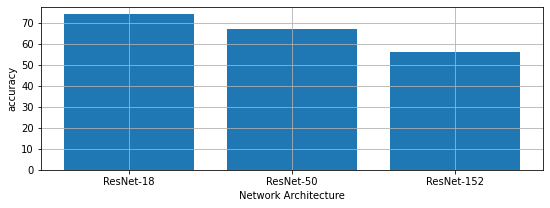

In [2]:
#ENTER CODE HERE
names = ['ResNet-18', 'ResNet-50', 'ResNet-152']
values = [74.02, 67.26, 55.99]

plt.figure(figsize=(9, 3))
plt.bar(names, values)
plt.xlabel('Network Architecture')
plt.ylabel('accuracy')
plt.grid(True)
plt.show()

Your answer -  Based on our results, ResNet-18 has outperformed the other two variants. Although it is true that the larger variants are more complicated and powerful, but freezing all weights and adding a linear function to fine-tune the model also needs a larger amount of data.
Besides, the 50 and 152 variants have more weights compared to the 18 one, and this leads to overfitness on our small dataset.

### **Part IV: Class Imbalance and Sampling [ 5 marks]**



In [ ]:
main_path = '/content/drive/MyDrive/datasets/imbalanced_data/train' #ENTER PATH HERE
test_path = '/content/drive/MyDrive/datasets/imbalanced_data/test' #ENTER PATH HERE

In [ ]:
'''
DO NOT ALTER THE FOLLOWING CODE
'''
'''
NEW CHANGE on 16th Novemeber, 2022
Add the line below
'''
torch.cuda.empty_cache()
torch.manual_seed(0)
'''
Add the above line
'''
'''
DO NOT ALTER THE FOLLOWING CODE
'''
my_transforms = transforms.Compose([transforms.Resize((224,224)),   transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
BATCH_SIZE = 16
IMAGE_SIZE = 32
NUM_CHANNELS = 3
n_epochs = 50 # the cnn will be trained for 50 epochs
dataset = datasets.ImageFolder(root=main_path, transform=my_transforms)
dataset_size = dataset.__len__() #compute the length of the training dataset
train_count = int(dataset_size * 0.8) #divide the training dataset to training and validation splits
val_count = dataset_size - train_count # keep the training proportion to 1 if no validation is required
train_dataset, valid_dataset = data.random_split(dataset, [train_count, val_count]) #perform a random split on the dataset based on the train and validation proportion
y_train_indices = train_dataset.indices
y_train = [dataset.targets[i] for i in y_train_indices] #assign the labels or target variables to y_train (classes)
test_data = datasets.ImageFolder(test_path, transform=my_transforms)
'''
Following train, validation and test dataloaders will also be used in Part III: Resnets
'''
'''
NEW CHANGE on 16th Novemeber, 2022
'''
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=2, )
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, )
'''
NEW CHANGE on 16th Novemeber, 2022
'''
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #check for gpu
print('Using ',device,'for model training') #print the device status

Using  cuda:0 for model training


In [ ]:
'''
DO NOT ALTER THE FOLLOWING CODE
'''
def train_model(model,n_epochs, loss_fn, train_step):
  '''
  This is the main function which is used to train the model, update weights, calculate loss and save the best model
  '''
  train_losses = []
  val_losses = []
  epoch_train_losses = []
  epoch_val_losses = []
  for epoch in range(n_epochs):
    epoch_loss = 0
    for i ,data in tqdm(enumerate(train_dataloader), total = len(train_dataloader)): #iterate ove batches
      x_batch , y_batch = data
      x_batch = x_batch.to('cuda') #move to gpu
      y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
      y_batch = y_batch.to('cuda') #move to gpu
      loss = train_step(x_batch, y_batch)
      epoch_loss += loss/len(train_dataloader) 
      train_losses.append(loss.cpu().detach().numpy())
    epoch_train_losses.append(epoch_loss)
    print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))
    #validation does not require gradient
    with torch.no_grad():
      cum_loss = 0
      for x_batch, y_batch in valid_dataloader:
        x_batch = x_batch.to('cuda')
        y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
        y_batch = y_batch.to('cuda')
        model.eval()#model to eval mode
        yhat = model(x_batch)
        val_loss = loss_fn(yhat,y_batch)
        cum_loss += loss/len(valid_dataloader)
        val_losses.append(val_loss.item())
      epoch_val_losses.append(cum_loss)
      print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))   
      best_loss = min(epoch_val_losses)  
      #save best model
      if cum_loss <= best_loss:
        best_model_wts = model.state_dict()  
  #load best model
  model.load_state_dict(best_model_wts)
  return model, train_losses,val_losses

def plot_losses(train_losses,val_losses):
  '''
  This function can be used to plot the training and validation losses. You can use this 
  function to analyse the losses and judge if model was overfitting or if model shows some 
  unusual behaviour. 
  '''
  plt.plot(train_losses, label='Training loss')
  plt.plot(val_losses, label='Validation loss')
  plt.legend()
  plt.show()

def inference(model,test_data):
  '''
  As we are doing binary classification, this function uses sigmoid to change class probabilities 
  to either 0 or 1 class. 
  '''
  y_pred = []
  y_true = []
  for idx in range(1, len(test_data)):
    y_true.append( test_data[idx][1])
    sample = torch.unsqueeze(test_data[idx][0], dim=0).to('cuda')
    if torch.sigmoid(model(sample)) < 0.5:
      y_pred.append(0)
    else:
      y_pred.append(1)
  return y_pred, y_true

def calc_loss(model, n_epochs):
  '''
  This function drives the training function, assigns the loss fuction and sets the optimiizer.
  '''
  loss_fn = BCEWithLogitsLoss() 
  optimizer = torch.optim.Adam(model.parameters()) 
  train_step = make_train_step(model, optimizer, loss_fn)
  trained_model, train_losses, val_losses = train_model(model,n_epochs, loss_fn, train_step)
  return trained_model

def calc_accuracy(trained_model):
  '''
  This function is used for returning the calculated accuracies.
  '''
  y_pred, y_true = inference(trained_model,test_data)
  target_names = ['Adults', 'Kids']
  print('the accuracy is',accuracy_score(y_true, y_pred))
  print(classification_report(y_true, y_pred, target_names=target_names))
  print('the balanced accuracy is',balanced_accuracy_score(y_true, y_pred))
  return accuracy_score(y_true, y_pred)

In [ ]:
from torch.nn.modules.conv import ConvTranspose2d, Conv2d
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(NUM_CHANNELS, IMAGE_SIZE, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(IMAGE_SIZE),
            nn.ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            nn.ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear_layers = Sequential(
            Linear(100352, 1)
        )

    def forward(self, x):

        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
'''
DO NOT ALTER THE FOLLOWING CODE
'''
model = Net()
optimizer = Adam(model.parameters(), lr=0.07)
criterion = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)
trained_model = calc_loss(model, n_epochs) #train the model
calc_accuracy(trained_model) # report the accuracy 

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=100352, out_features=1, bias=True)
  )
)


100%|██████████| 22/22 [00:33<00:00,  1.54s/it]


Epoch : 1, train loss : 1.934457778930664


Epoch : 1, val loss : 0.034507352858781815


100%|██████████| 22/22 [00:03<00:00,  6.64it/s]


Epoch : 2, train loss : 1.3059847354888916


Epoch : 2, val loss : 0.04329577460885048


100%|██████████| 22/22 [00:03<00:00,  7.32it/s]


Epoch : 3, train loss : 0.7364428639411926


Epoch : 3, val loss : 0.0012746379943564534


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Epoch : 4, train loss : 0.4248720109462738


Epoch : 4, val loss : 1.3978945016860962


100%|██████████| 22/22 [00:01<00:00, 11.68it/s]


Epoch : 5, train loss : 1.0044684410095215


Epoch : 5, val loss : 8.940690463532519e-07


100%|██████████| 22/22 [00:01<00:00, 11.35it/s]


Epoch : 6, train loss : 0.49018800258636475


Epoch : 6, val loss : 0.0003001987060997635


100%|██████████| 22/22 [00:01<00:00, 11.76it/s]


Epoch : 7, train loss : 0.33993756771087646


Epoch : 7, val loss : 0.06179753690958023


100%|██████████| 22/22 [00:01<00:00, 11.85it/s]


Epoch : 8, train loss : 0.7230619788169861


Epoch : 8, val loss : 0.00011675187124637887


100%|██████████| 22/22 [00:01<00:00, 11.61it/s]


Epoch : 9, train loss : 0.4008381962776184


Epoch : 9, val loss : 0.009834682568907738


100%|██████████| 22/22 [00:03<00:00,  7.15it/s]


Epoch : 10, train loss : 0.135078564286232


Epoch : 10, val loss : 1.7523458154755645e-05


100%|██████████| 22/22 [00:01<00:00, 11.51it/s]


Epoch : 11, train loss : 0.027631863951683044


Epoch : 11, val loss : 5.137656626175158e-05


100%|██████████| 22/22 [00:01<00:00, 11.12it/s]


Epoch : 12, train loss : 0.03832264989614487


Epoch : 12, val loss : 0.0012375286314636469


100%|██████████| 22/22 [00:03<00:00,  7.32it/s]


Epoch : 13, train loss : 0.028267214074730873


Epoch : 13, val loss : 0.26363635063171387


100%|██████████| 22/22 [00:02<00:00,  9.78it/s]


Epoch : 14, train loss : 0.1990559697151184


Epoch : 14, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.41it/s]


Epoch : 15, train loss : 0.0728691890835762


Epoch : 15, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.64it/s]


Epoch : 16, train loss : 0.020121991634368896


Epoch : 16, val loss : 0.33367204666137695


100%|██████████| 22/22 [00:01<00:00, 11.81it/s]


Epoch : 17, train loss : 0.2814812958240509


Epoch : 17, val loss : 0.005299340467900038


100%|██████████| 22/22 [00:01<00:00, 11.68it/s]


Epoch : 18, train loss : 0.0897313803434372


Epoch : 18, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.80it/s]


Epoch : 19, train loss : 0.041115060448646545


Epoch : 19, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.51it/s]


Epoch : 20, train loss : 0.022992437705397606


Epoch : 20, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.63it/s]


Epoch : 21, train loss : 0.00025546932010911405


Epoch : 21, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.61it/s]



Epoch : 22, train loss : 6.700370431644842e-05
Epoch : 22, val loss : 4.7323850594693795e-05


100%|██████████| 22/22 [00:01<00:00, 11.41it/s]


Epoch : 23, train loss : 1.9371858797967434e-05


Epoch : 23, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.32it/s]


Epoch : 24, train loss : 7.573356560897082e-05


Epoch : 24, val loss : 1.6689275526005076e-06


100%|██████████| 22/22 [00:01<00:00, 11.33it/s]


Epoch : 25, train loss : 1.0190114153374452e-05


Epoch : 25, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.67it/s]


Epoch : 26, train loss : 8.998943485494237e-06


Epoch : 26, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.30it/s]


Epoch : 27, train loss : 5.816696102556307e-06


Epoch : 27, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.44it/s]


Epoch : 28, train loss : 7.6052201620768756e-06


Epoch : 28, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.66it/s]


Epoch : 29, train loss : 1.6833106201374903e-05


Epoch : 29, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.63it/s]


Epoch : 30, train loss : 6.871110599604435e-06


Epoch : 30, val loss : 0.0


100%|██████████| 22/22 [00:02<00:00,  8.24it/s]


Epoch : 31, train loss : 4.196652298560366e-05


Epoch : 31, val loss : 0.0007086140685714781


100%|██████████| 22/22 [00:02<00:00, 10.32it/s]


Epoch : 32, train loss : 4.501029707171256e-06


Epoch : 32, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.66it/s]


Epoch : 33, train loss : 0.01180153526365757


Epoch : 33, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.00it/s]



Epoch : 34, train loss : 0.04289476200938225
Epoch : 34, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.47it/s]


Epoch : 35, train loss : 0.032927241176366806


Epoch : 35, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.51it/s]


Epoch : 36, train loss : 0.24773941934108734


Epoch : 36, val loss : 0.02930843085050583


100%|██████████| 22/22 [00:02<00:00,  9.69it/s]


Epoch : 37, train loss : 0.132914736866951


Epoch : 37, val loss : 0.0


100%|██████████| 22/22 [00:02<00:00,  9.80it/s]


Epoch : 38, train loss : 0.06753364205360413


Epoch : 38, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.69it/s]


Epoch : 39, train loss : 0.0489567369222641


Epoch : 39, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.59it/s]


Epoch : 40, train loss : 0.005897128023207188


Epoch : 40, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.44it/s]


Epoch : 41, train loss : 0.0018665837123990059


Epoch : 41, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.61it/s]


Epoch : 42, train loss : 0.0008140868740156293


Epoch : 42, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.67it/s]


Epoch : 43, train loss : 0.0002240426401840523


Epoch : 43, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.32it/s]


Epoch : 44, train loss : 5.551737103814958e-06


Epoch : 44, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.47it/s]


Epoch : 45, train loss : 1.2433804840839002e-05


Epoch : 45, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.33it/s]


Epoch : 46, train loss : 0.00010192976333200932


Epoch : 46, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.25it/s]


Epoch : 47, train loss : 6.71055204293225e-06


Epoch : 47, val loss : 5.709799734177068e-05


100%|██████████| 22/22 [00:01<00:00, 11.64it/s]


Epoch : 48, train loss : 1.0027823009295389e-05


Epoch : 48, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.61it/s]


Epoch : 49, train loss : 4.78048332297476e-06


Epoch : 49, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.49it/s]


Epoch : 50, train loss : 4.020795131509658e-06


Epoch : 50, val loss : 0.0
the accuracy is 0.5546218487394958
              precision    recall  f1-score   support

      Adults       0.53      0.97      0.68        59
        Kids       0.82      0.15      0.25        60

    accuracy                           0.55       119
   macro avg       0.67      0.56      0.47       119
weighted avg       0.67      0.55      0.47       119

the balanced accuracy is 0.5580508474576271


0.5546218487394958

In [ ]:
df = pd.DataFrame(y_train)
a = df.value_counts()

In [ ]:
weights = []
for i in range(a.size):
  weights.append(a[i]/len(y_train))

weights.reverse()

In [ ]:
weights_array = torch.from_numpy(np.array([weights[i] for i in y_train]))
sampler_W = WeightedRandomSampler(weights_array.type('torch.DoubleTensor'), len(y_train), replacement=True)

In [ ]:
'''
DO NOT ALTER THE FOLLOWING CODE
'''
'''
NEW CHANGE on 16th Novemeber, 2022
Add the line below
'''
torch.cuda.empty_cache()
torch.manual_seed(0)
'''
Add the above line
'''
'''
DO NOT ALTER THE FOLLOWING CODE
'''
my_transforms = transforms.Compose([transforms.Resize((224,224)),   transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
BATCH_SIZE = 16
IMAGE_SIZE = 32
NUM_CHANNELS = 3
n_epochs = 50 # the cnn will be trained for 50 epochs
dataset = datasets.ImageFolder(root=main_path, transform=my_transforms)
dataset_size = dataset.__len__() #compute the length of the training dataset
train_count = int(dataset_size * 0.8) #divide the training dataset to training and validation splits
val_count = dataset_size - train_count # keep the training proportion to 1 if no validation is required
train_dataset, valid_dataset = data.random_split(dataset, [train_count, val_count]) #perform a random split on the dataset based on the train and validation proportion
y_train_indices = train_dataset.indices
y_train = [dataset.targets[i] for i in y_train_indices] #assign the labels or target variables to y_train (classes)
test_data = datasets.ImageFolder(test_path, transform=my_transforms)
'''
Following train, validation and test dataloaders will also be used in Part III: Resnets
'''
'''
NEW CHANGE on 16th Novemeber, 2022
'''
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2, sampler = sampler_W)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, )
'''
NEW CHANGE on 16th Novemeber, 2022
'''
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #check for gpu
print('Using ',device,'for model training') #print the device status

Using  cuda:0 for model training


In [ ]:
'''
DO NOT ALTER THE FOLLOWING CODE
'''
def train_model(model,n_epochs, loss_fn, train_step):
  '''
  This is the main function which is used to train the model, update weights, calculate loss and save the best model
  '''
  train_losses = []
  val_losses = []
  epoch_train_losses = []
  epoch_val_losses = []
  for epoch in range(n_epochs):
    epoch_loss = 0
    for i ,data in tqdm(enumerate(train_dataloader), total = len(train_dataloader)): #iterate ove batches
      x_batch , y_batch = data
      x_batch = x_batch.to('cuda') #move to gpu
      y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
      y_batch = y_batch.to('cuda') #move to gpu
      loss = train_step(x_batch, y_batch)
      epoch_loss += loss/len(train_dataloader) 
      train_losses.append(loss.cpu().detach().numpy())
    epoch_train_losses.append(epoch_loss)
    print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))
    #validation does not require gradient
    with torch.no_grad():
      cum_loss = 0
      for x_batch, y_batch in valid_dataloader:
        x_batch = x_batch.to('cuda')
        y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
        y_batch = y_batch.to('cuda')
        model.eval()#model to eval mode
        yhat = model(x_batch)
        val_loss = loss_fn(yhat,y_batch)
        cum_loss += loss/len(valid_dataloader)
        val_losses.append(val_loss.item())
      epoch_val_losses.append(cum_loss)
      print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))   
      best_loss = min(epoch_val_losses)  
      #save best model
      if cum_loss <= best_loss:
        best_model_wts = model.state_dict()  
  #load best model
  model.load_state_dict(best_model_wts)
  return model, train_losses,val_losses

def plot_losses(train_losses,val_losses):
  '''
  This function can be used to plot the training and validation losses. You can use this 
  function to analyse the losses and judge if model was overfitting or if model shows some 
  unusual behaviour. 
  '''
  plt.plot(train_losses, label='Training loss')
  plt.plot(val_losses, label='Validation loss')
  plt.legend()
  plt.show()

def inference(model,test_data):
  '''
  As we are doing binary classification, this function uses sigmoid to change class probabilities 
  to either 0 or 1 class. 
  '''
  y_pred = []
  y_true = []
  for idx in range(1, len(test_data)):
    y_true.append( test_data[idx][1])
    sample = torch.unsqueeze(test_data[idx][0], dim=0).to('cuda')
    if torch.sigmoid(model(sample)) < 0.5:
      y_pred.append(0)
    else:
      y_pred.append(1)
  return y_pred, y_true

def calc_loss(model, n_epochs):
  '''
  This function drives the training function, assigns the loss fuction and sets the optimiizer.
  '''
  loss_fn = BCEWithLogitsLoss() 
  optimizer = torch.optim.Adam(model.parameters()) 
  train_step = make_train_step(model, optimizer, loss_fn)
  trained_model, train_losses, val_losses = train_model(model,n_epochs, loss_fn, train_step)
  return trained_model

def calc_accuracy(trained_model):
  '''
  This function is used for returning the calculated accuracies.
  '''
  y_pred, y_true = inference(trained_model,test_data)
  target_names = ['Adults', 'Kids']
  print('the accuracy is',accuracy_score(y_true, y_pred))
  print(classification_report(y_true, y_pred, target_names=target_names))
  print('the imbalanced accuracy is',balanced_accuracy_score(y_true, y_pred))
  return accuracy_score(y_true, y_pred)

In [ ]:
from torch.nn.modules.conv import ConvTranspose2d, Conv2d
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(NUM_CHANNELS, IMAGE_SIZE, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(IMAGE_SIZE),
            nn.ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            nn.ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear_layers = Sequential(
            Linear(100352, 1)
        )

    def forward(self, x):

        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
'''
DO NOT ALTER THE FOLLOWING CODE
'''
model = Net()
optimizer = Adam(model.parameters(), lr=0.07)
criterion = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)
trained_model = calc_loss(model, n_epochs) #train the model
calc_accuracy(trained_model) # report the accuracy 

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=100352, out_features=1, bias=True)
  )
)


100%|██████████| 22/22 [00:02<00:00, 10.58it/s]


Epoch : 1, train loss : 4.849077224731445


Epoch : 1, val loss : 15.893762588500977


100%|██████████| 22/22 [00:01<00:00, 11.79it/s]


Epoch : 2, train loss : 1.8729767799377441


Epoch : 2, val loss : 0.6364385485649109


100%|██████████| 22/22 [00:01<00:00, 11.61it/s]


Epoch : 3, train loss : 1.8554255962371826


Epoch : 3, val loss : 5.459274768829346


100%|██████████| 22/22 [00:01<00:00, 11.87it/s]



Epoch : 4, train loss : 0.6976482272148132
Epoch : 4, val loss : 0.0729295015335083


100%|██████████| 22/22 [00:01<00:00, 11.75it/s]


Epoch : 5, train loss : 0.19458764791488647


Epoch : 5, val loss : 0.0


100%|██████████| 22/22 [00:03<00:00,  6.16it/s]


Epoch : 6, train loss : 0.06293935328722


Epoch : 6, val loss : 0.012083441950380802


100%|██████████| 22/22 [00:01<00:00, 11.88it/s]


Epoch : 7, train loss : 0.03263828530907631


Epoch : 7, val loss : 0.12715104222297668


100%|██████████| 22/22 [00:01<00:00, 11.01it/s]


Epoch : 8, train loss : 0.10608076304197311


Epoch : 8, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.74it/s]


Epoch : 9, train loss : 0.030040163546800613


Epoch : 9, val loss : 4.172324281626061e-07


100%|██████████| 22/22 [00:01<00:00, 11.81it/s]


Epoch : 10, train loss : 0.06413204222917557


Epoch : 10, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.72it/s]


Epoch : 11, train loss : 0.05545088276267052


Epoch : 11, val loss : 3.278245003457414e-06


100%|██████████| 22/22 [00:02<00:00,  7.47it/s]


Epoch : 12, train loss : 0.01124836690723896


Epoch : 12, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.91it/s]


Epoch : 13, train loss : 0.013114611618220806


Epoch : 13, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.64it/s]


Epoch : 14, train loss : 0.07197269797325134


Epoch : 14, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.51it/s]


Epoch : 15, train loss : 0.009086973965168


Epoch : 15, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.58it/s]


Epoch : 16, train loss : 0.032892968505620956


Epoch : 16, val loss : 0.5221604108810425


100%|██████████| 22/22 [00:01<00:00, 11.54it/s]


Epoch : 17, train loss : 0.24680115282535553


Epoch : 17, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.52it/s]


Epoch : 18, train loss : 0.38227856159210205


Epoch : 18, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.62it/s]


Epoch : 19, train loss : 0.13827362656593323


Epoch : 19, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.50it/s]


Epoch : 20, train loss : 0.3472025394439697


Epoch : 20, val loss : 1.06243896484375


100%|██████████| 22/22 [00:01<00:00, 11.72it/s]


Epoch : 21, train loss : 0.27002623677253723


Epoch : 21, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.78it/s]


Epoch : 22, train loss : 0.07021751999855042


Epoch : 22, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.81it/s]


Epoch : 23, train loss : 0.15478958189487457


Epoch : 23, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.72it/s]


Epoch : 24, train loss : 0.13931439816951752


Epoch : 24, val loss : 1.5914187315502204e-05


100%|██████████| 22/22 [00:01<00:00, 11.82it/s]


Epoch : 25, train loss : 0.03143881633877754


Epoch : 25, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.61it/s]


Epoch : 26, train loss : 0.014641609974205494


Epoch : 26, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.40it/s]


Epoch : 27, train loss : 0.004604624584317207


Epoch : 27, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.74it/s]


Epoch : 28, train loss : 0.01298522762954235


Epoch : 28, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.47it/s]


Epoch : 29, train loss : 0.008058582432568073


Epoch : 29, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.86it/s]


Epoch : 30, train loss : 0.022076085209846497


Epoch : 30, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.21it/s]


Epoch : 31, train loss : 0.04103368520736694


Epoch : 31, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.60it/s]


Epoch : 32, train loss : 0.01319878175854683


Epoch : 32, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.70it/s]


Epoch : 33, train loss : 0.0007626995793543756


Epoch : 33, val loss : 0.0


100%|██████████| 22/22 [00:03<00:00,  7.26it/s]


Epoch : 34, train loss : 2.3176035028882325e-06


Epoch : 34, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.56it/s]


Epoch : 35, train loss : 1.76804235252348e-06


Epoch : 35, val loss : 0.0


100%|██████████| 22/22 [00:02<00:00,  8.70it/s]


Epoch : 36, train loss : 0.0009439645800739527


Epoch : 36, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.57it/s]


Epoch : 37, train loss : 4.666095628635958e-05


Epoch : 37, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.60it/s]


Epoch : 38, train loss : 1.645822158025112e-05


Epoch : 38, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.64it/s]


Epoch : 39, train loss : 0.000137192546389997


Epoch : 39, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.61it/s]


Epoch : 40, train loss : 4.0303816604136955e-06


Epoch : 40, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 12.07it/s]


Epoch : 41, train loss : 2.6082056137965992e-05


Epoch : 41, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.17it/s]


Epoch : 42, train loss : 5.2316886467451695e-06


Epoch : 42, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.50it/s]


Epoch : 43, train loss : 1.5208518107101554e-06


Epoch : 43, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.45it/s]


Epoch : 44, train loss : 1.25706692415406e-05


Epoch : 44, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.69it/s]


Epoch : 45, train loss : 6.637381375185214e-06


Epoch : 45, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.56it/s]


Epoch : 46, train loss : 4.12832423535292e-06


Epoch : 46, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.62it/s]


Epoch : 47, train loss : 4.861735305894399e-06


Epoch : 47, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.53it/s]


Epoch : 48, train loss : 1.197456754198356e-06


Epoch : 48, val loss : 2.9802313861182483e-07


100%|██████████| 22/22 [00:01<00:00, 11.69it/s]


Epoch : 49, train loss : 1.090073783416301e-05


Epoch : 49, val loss : 0.0


100%|██████████| 22/22 [00:01<00:00, 11.79it/s]


Epoch : 50, train loss : 6.237190063984599e-06


Epoch : 50, val loss : 0.00010364174522692338
the accuracy is 0.5882352941176471
              precision    recall  f1-score   support

      Adults       0.55      0.98      0.70        59
        Kids       0.92      0.20      0.33        60

    accuracy                           0.59       119
   macro avg       0.74      0.59      0.52       119
weighted avg       0.74      0.59      0.51       119

the imbalanced accuracy is 0.5915254237288136


0.5882352941176471


**Consider the imbalanced data and run the following CNN with and without Weighted Random Sampler**



```
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(NUM_CHANNELS, IMAGE_SIZE, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(IMAGE_SIZE),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(100352, 1)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        #x = x.view(x.size(0), -1)

        return x
        
```


**NOTE:** 
1. Change the main and test paths to the imbalanced dataset.
2. Sampler can be loaded to data loader as follows:



```
sampler_W = <ENTER CODE for weighted sampler>

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2, sampler = sampler_W)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=2)
```

**Has the accuracy gone up or down? Why? Explain your answer.**


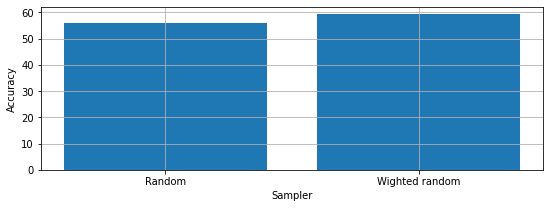

In [4]:
#ENTER CODE HERE
names = ['Random', 'Wighted random']
values = [55.8, 59.15]

plt.figure(figsize=(9, 3))
plt.bar(names, values)
plt.xlabel('Sampler')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Answer - The accuracy has gone up. In cases where we have impbalanced datasets, random sampling leads to a network that has a bias towards the larger class. By using a wighted random sampler, we try to assign an equal probability to each data from any label. Hence, the network will be fed by the same amount of data from each class and won't be biased.

### **Part V: Data Augmentation{CMPUT 466 only}[ 5 marks]**
1. **What is Data Augmentation? How does it help in combating the data imbalance issue?**

Answer - 

2. **Rotate** the image clockwise by **30** degrees

In [ ]:
# importing an image from the imbalanced dataset
image_path = <import any random image from the dataset> #ENTER THE PATH
'''
DO NOT ALTER THE FOLLOWING CODE
HOWEVER, IF YOU WANT TO ANOTHER LIBRARY, FEEL FREE TO USE IT TOO.
JUST MAKE SURE TO DO THE AUGMENTATION AND THEN SHOW THE AUGMENTED IMAGE
'''

import imageio
import imgaug as ia
import imgaug.augmenters as iaa
%matplotlib inline
image = imageio.imread(image_path)
ia.imshow(image)

# Your code to rotate the image then show it. Use ia.imshow(image) if using imgaug library

##

3. Add **Gaussian noise** to the image. 


In [ ]:
## YOUR CODE TO ADD GAUSSIAN NOISE TO THE IMAGE

4. Convolve the image by applying [**Sobel Edge Detection**](https://www.projectrhea.org/rhea/index.php/An_Implementation_of_Sobel_Edge_Detection) filter. You can apply either X or Y directional kernel and use any library.


In [ ]:
## YOUR CODE FOR SOBEL EDGE DETECTION

5. Think of **two cases** where augmentations might **not be useful**. For instance, in digits classification, applying a flipping augmentation for the digit 2 might be of no use. 

Answer - 